## Lectura de Datos

In [1]:
# Cargar el archivo CSV desde el directorio local
install.packages("rio")
library(rio)
data <- rio::import("~/GitHub/SOLAR_LCOE_UY/data/raw/RadiationSim2024_2044.csv")
#data <- read.csv(DB_rad)




Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



## Instalación y carga de librerías

In [2]:
install.packages("triangle")

library(tidyverse)
library(triangle)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


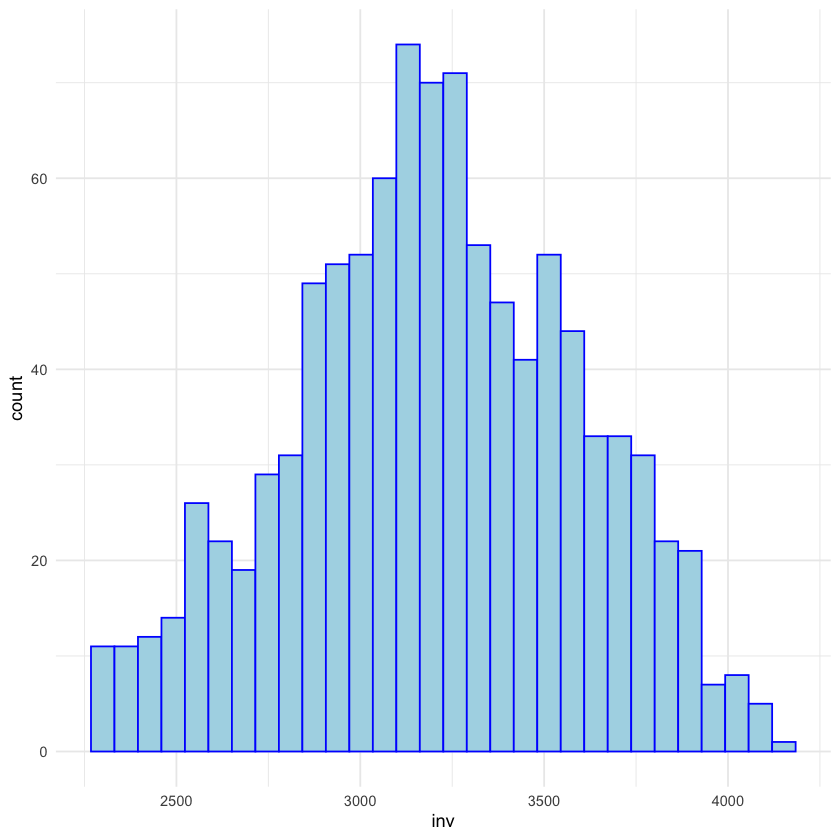

`summarise()` has grouped output by 'id'. You can override using the `.groups`
argument.
Joining with `by = join_by(id)`


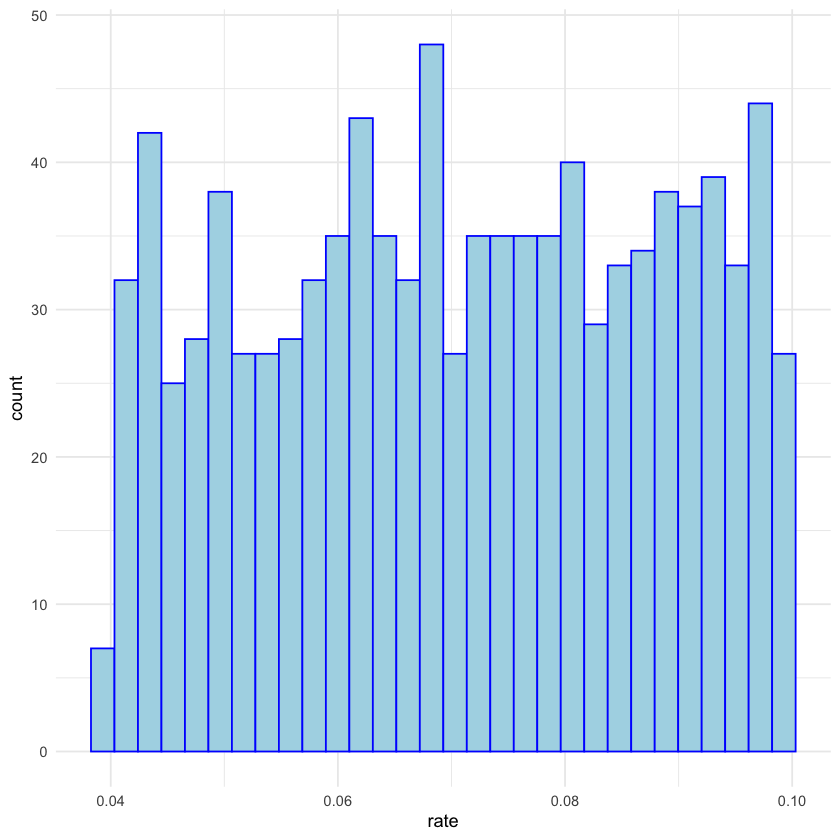

In [3]:
# average 5.44 paper

set.seed(1995)

Par_MonteCarlo <- tibble(id = seq(1,1000),
                         inv = rtriangle(1000, 2230, 4150, 3190),#capex
                         rate = runif(1000, 0.04,0.1 ) )# wacc

Par_MonteCarlo |>
  ggplot(aes(inv))+
  geom_histogram( color = "blue", fill = "lightblue" )+
  theme_minimal()

Par_MonteCarlo |>
  ggplot(aes(rate))+
  geom_histogram( color = "blue", fill = "lightblue" )+
  theme_minimal()


#DB_rad <- read_csv("RadiationSim2024_2044.csv")


Scenarios <- data |> group_by(id) |>
  mutate( year = year(date), Output = (value/1000)*0.153*6.455*1)|>
  group_by(id,year) |>
  summarise(yearlyoutput = sum(Output))|>
  group_by(id) |>
  left_join(  Par_MonteCarlo  ) |>
  mutate(t = year-2020,
         FDf =  yearlyoutput*(1/(1 + rate )^t)) |>
  summarise(Inv = mean(inv),
            VPf = sum(FDf))|>
  mutate(LCOE = (Inv/VPf)*1000 )











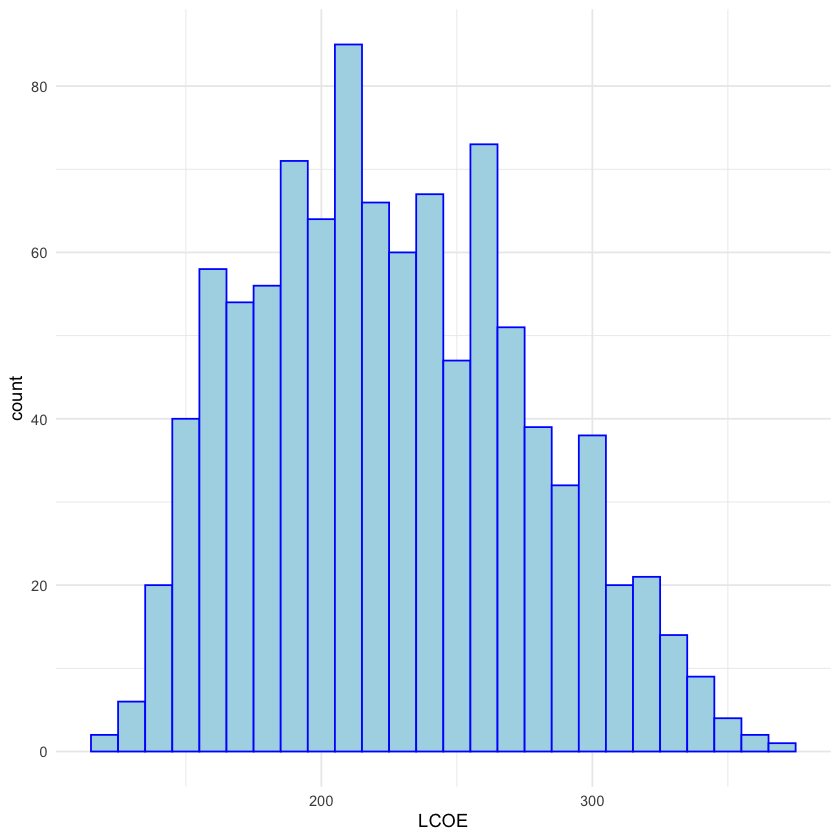

In [4]:
Scenarios |>
  ggplot(aes(LCOE))+
  geom_histogram(binwidth = 10, color = "blue", fill = "lightblue" )+
  theme_minimal()

In [5]:
names(Scenarios)

[1] "id"   "Inv"  "VPf"  "LCOE"

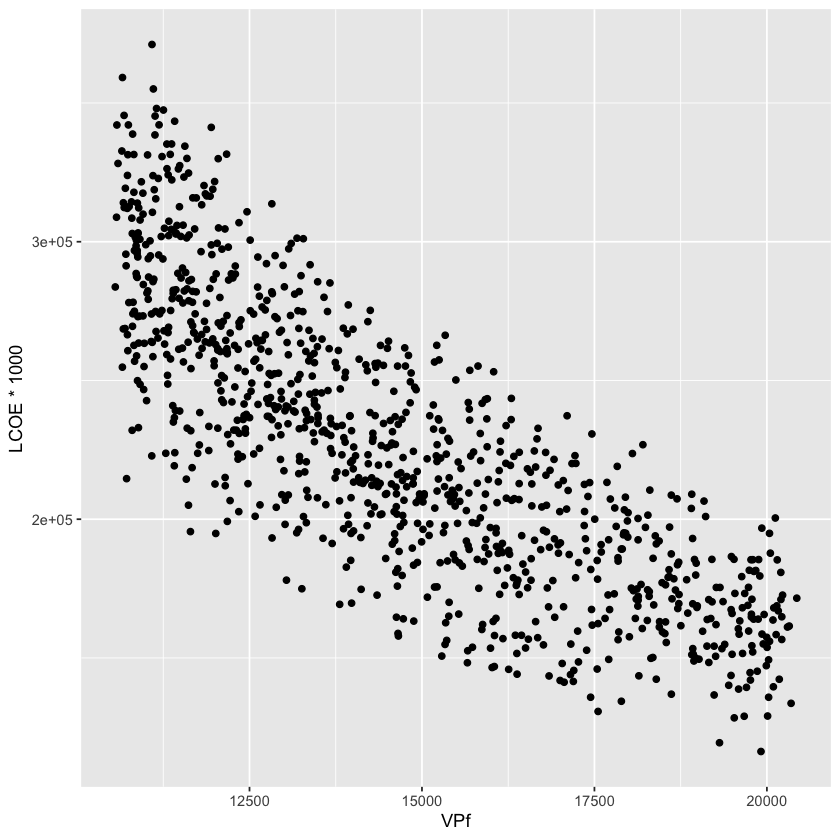

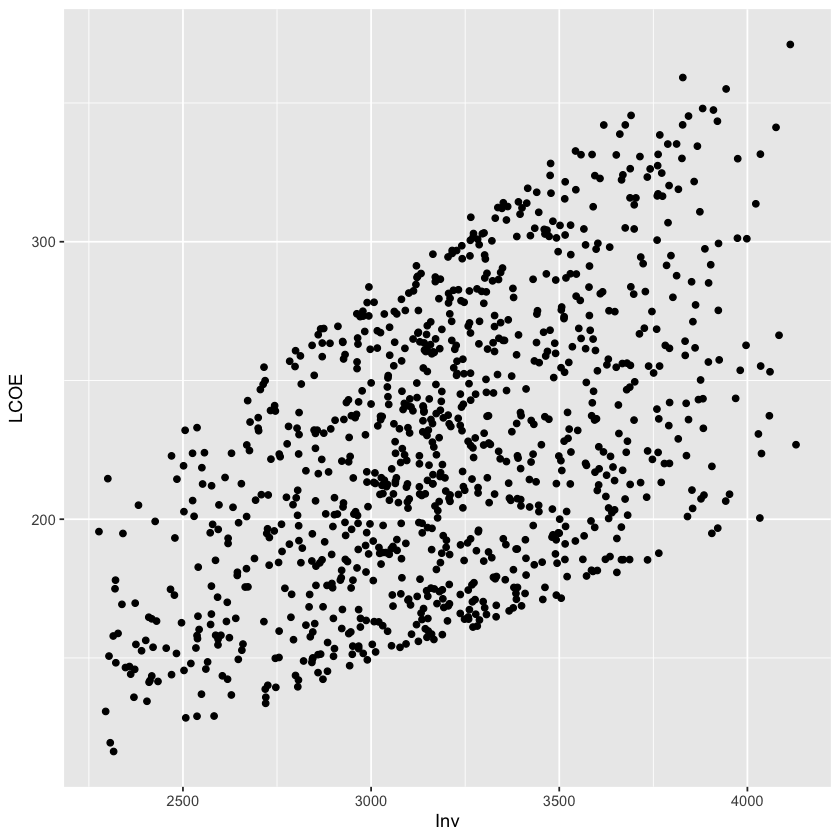

In [6]:
 Scenarios |>
    ggplot(aes(VPf, LCOE*1000))+
    geom_point()
  Scenarios |>
    ggplot(aes(Inv, LCOE))+
    geom_point()


## Graficos nuestros?

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


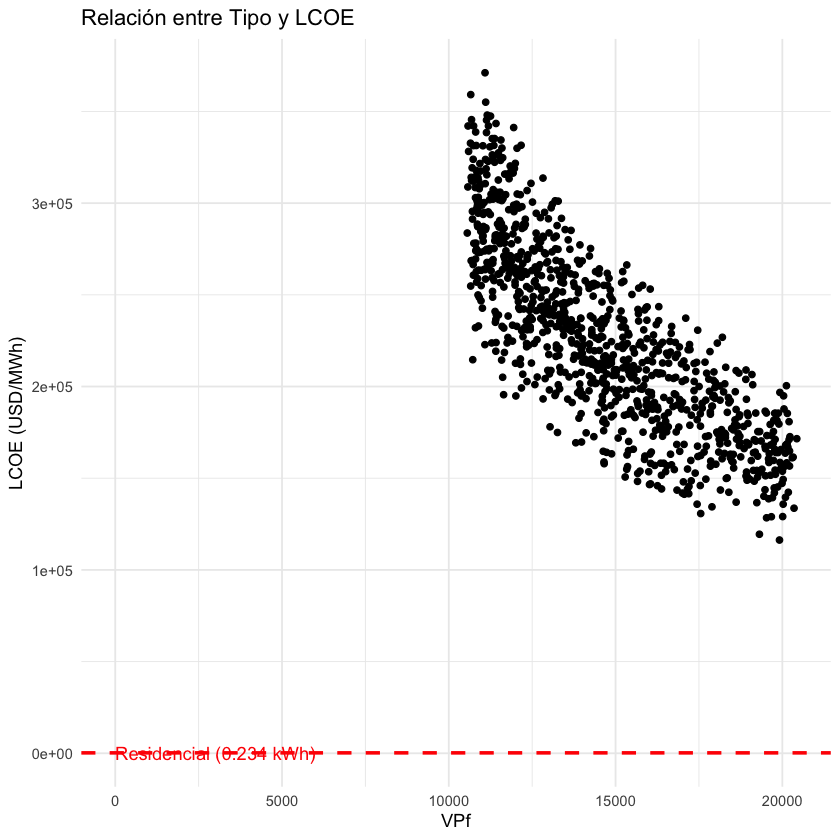

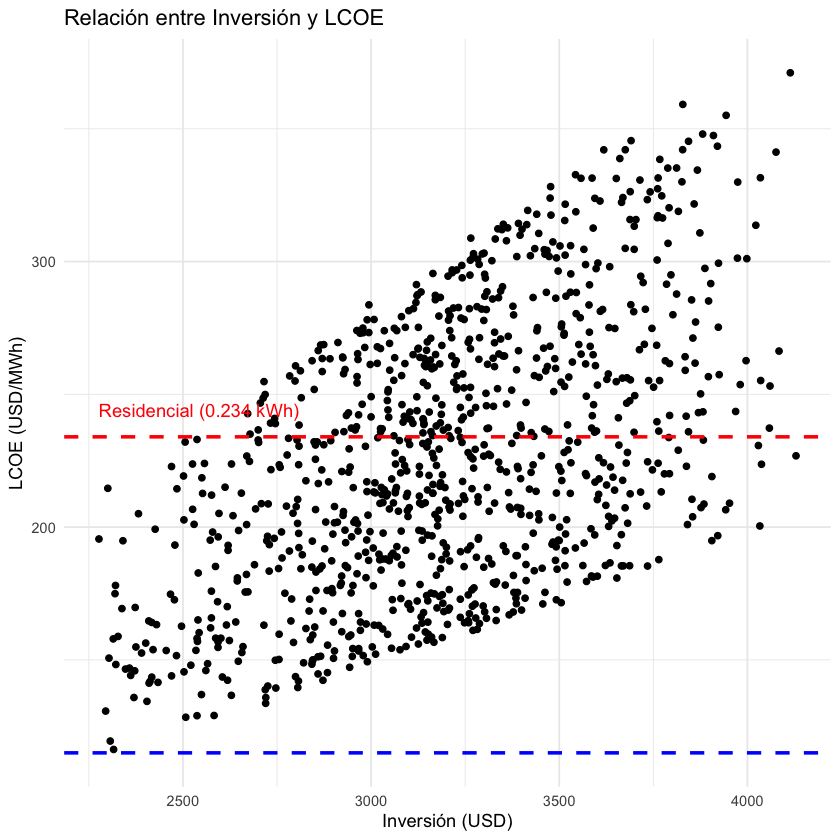

In [7]:
#opcion 1 (la que envie hoy por wpp)
library(tidyverse)

# Cargar los datos de Scenarios
Scenarios <- data |>
  group_by(id) |>
  mutate(year = year(date), Output = (value/1000) * 0.153 * 6.455 * 1) |>
  group_by(id, year) |>
  summarise(yearlyoutput = sum(Output), .groups = 'drop') |>
  group_by(id) |>
  left_join(Par_MonteCarlo, by = "id") |>
  mutate(t = year - 2020,
         FDf = yearlyoutput * (1 / (1 + rate)^t)) |>
  summarise(Inv = mean(inv), VPf = sum(FDf), .groups = 'drop') |>
  mutate(LCOE = (Inv / VPf) * 1000)

# Definir valores de referencia
residencial_ref <- 0.234 * 1000  # Convertir a la misma escala que LCOE
negocio_ref <- 0.115 * 1000  # Convertir a la misma escala que LCOE

# Gráfico 1: Relación entre Tipo y LCOE
Scenarios |>
  ggplot(aes(VPf, LCOE * 1000)) +
  geom_point() +
  geom_hline(yintercept = residencial_ref, color = "red", linetype = "dashed", size = 1) +
  annotate("text", x = 1, y = residencial_ref + 10, label = "Residencial (0.234 kWh)", color = "red", hjust = 0) +

  labs(title = "Relación entre Tipo y LCOE",
       x = "VPf",
       y = "LCOE (USD/MWh)") +
  theme_minimal()

# Gráfico 2: Relación entre Inversión y LCOE
Scenarios |>
  ggplot(aes(Inv, LCOE)) +
  geom_point() +
  geom_hline(yintercept = residencial_ref, color = "red", linetype = "dashed", size = 1) +
  geom_hline(yintercept = negocio_ref, color = "blue", linetype = "dashed", size = 1) +
  annotate("text", x = min(Scenarios$Inv), y = residencial_ref + 10, label = "Residencial (0.234 kWh)", color = "red", hjust = 0) +
  labs(title = "Relación entre Inversión y LCOE",
       x = "Inversión (USD)",
       y = "LCOE (USD/MWh)") +
  theme_minimal()


`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?


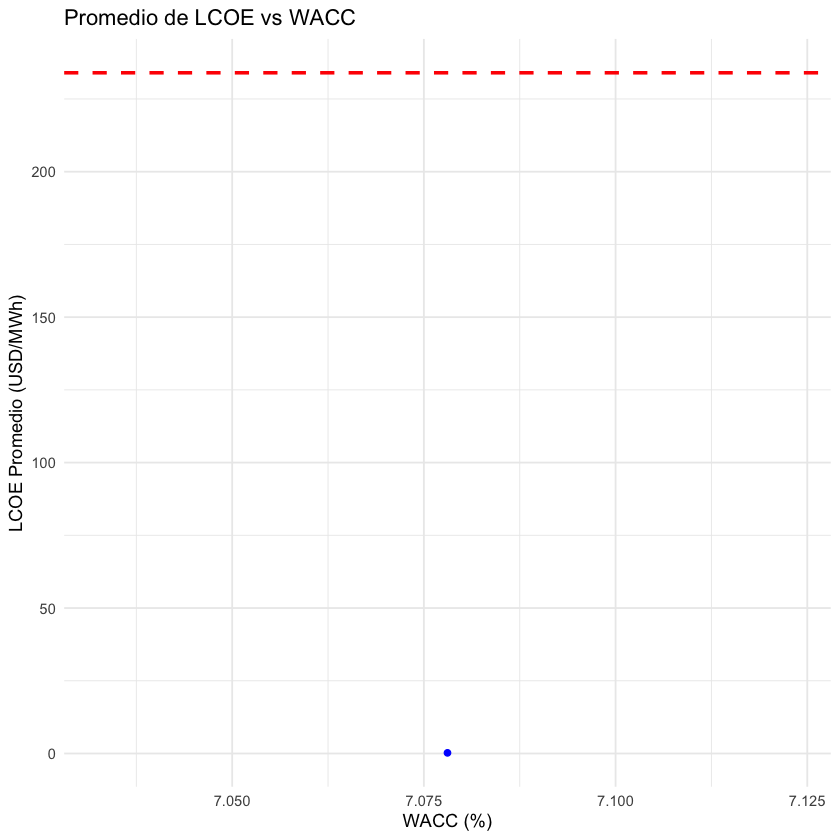

In [8]:
library(tidyverse)
library(triangle)

# Set seed for reproducibility
set.seed(1995)

# Monte Carlo Simulation Parameters
Par_MonteCarlo <- tibble(
  id = seq(1, 1000),
  inv = rtriangle(1000, 2230, 4150, 3190),  # CAPEX
  rate = runif(1000, 0.04, 0.1)  # WACC
)

# Load Radiation Data
DB_rad <- rio::import("~/GitHub/SOLAR_LCOE_UY/data/raw/RadiationSim2024_2044.csv")

# Compute Scenarios
Scenarios <- DB_rad |>
  group_by(id) |>
  mutate(
    year = year(date),
    Output = (value / 1000) * 0.153 * 6.455 * 1
  ) |>
  group_by(id, year) |>
  summarise(yearlyoutput = sum(Output), .groups = "drop") |>
  left_join(Par_MonteCarlo, by = "id") |>
  mutate(
    t = year - 2020,
    FDf = yearlyoutput * (1 / (1 + rate) ^ t)
  ) |>
  summarise(
    rate = mean(rate),
    Inv = mean(inv),
    VPf = sum(FDf),
    .groups = "drop"
  ) |>
  mutate(LCOE = (Inv / VPf) * 1000)

# Agrupar por WACC y calcular el promedio del LCOE
LCOE_avg <- Scenarios |>
  group_by(rate) |>
  summarise(LCOE_mean = mean(LCOE), .groups = "drop")

# Plot LCOE promedio vs WACC con líneas de referencia
ggplot(LCOE_avg, aes(x = rate * 100, y = LCOE_mean)) +
  geom_line(color = "blue", size = 1) +
  geom_point(color = "blue") +
  geom_hline(yintercept = 0.234 * 1000, linetype = "dashed", color = "red", size = 1) +  # Residencial
  labs(
    x = "WACC (%)",
    y = "LCOE Promedio (USD/MWh)",
    title = "Promedio de LCOE vs WACC"
  ) +
  theme_minimal()


`geom_smooth()` using formula = 'y ~ x'


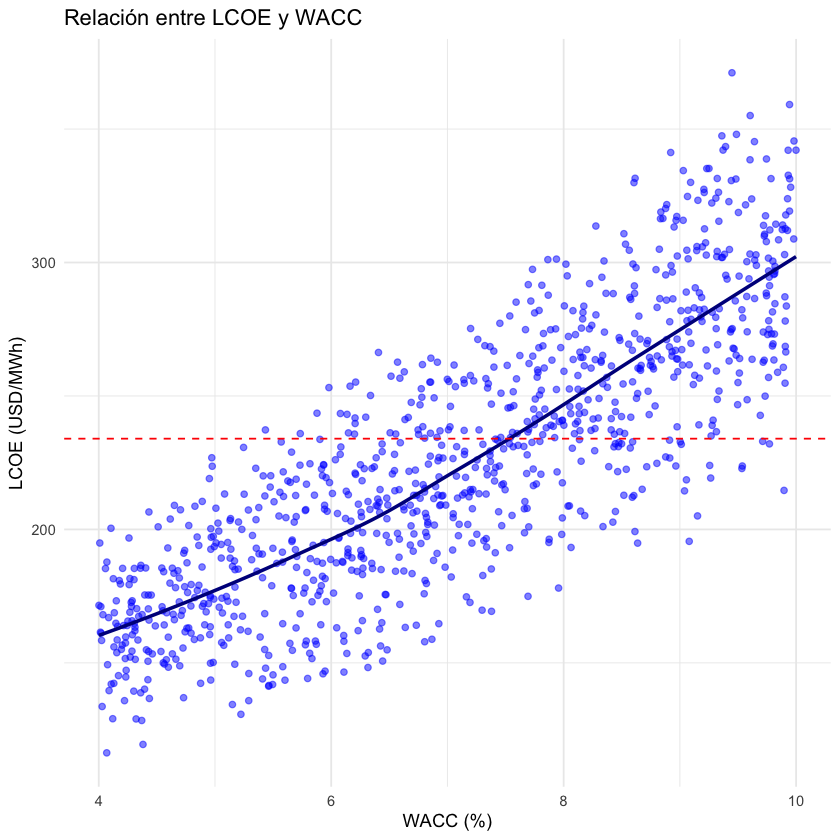

In [9]:
library(tidyverse)
library(triangle)
library(lubridate)
library(rio)

# Set seed for reproducibility
set.seed(1995)

# Monte Carlo Simulation Parameters
Par_MonteCarlo <- tibble(
  id = seq(1, 1000),
  inv = rtriangle(1000, 2230, 4150, 3190),  # CAPEX en USD/kWp
  rate = runif(1000, 0.04, 0.1)  # WACC
)

# Load Radiation Data
DB_rad <- rio::import("~/GitHub/SOLAR_LCOE_UY/data/raw/RadiationSim2024_2044.csv")

# Compute Scenarios
Scenarios <- DB_rad |>
  group_by(id) |>
  mutate(
    year = year(date),
    Output = (value / 1000) * 0.153 * 6.455 * 1  # Producción en MWh
  ) |>
  group_by(id, year) |>
  summarise(yearlyoutput = sum(Output), .groups = "drop") |>
  left_join(Par_MonteCarlo, by = "id") |>
  mutate(
    t = year - 2020,
    FDf = yearlyoutput * (1 / (1 + rate) ^ t)
  ) |>
  group_by(id) |>
  summarise(
    rate = mean(rate),
    Inv = mean(inv),
    VPf = sum(FDf),
    .groups = "drop"
  ) |>
  mutate(
    LCOE = (Inv / VPf) * 1000  # USD/MWh
  )

# Plot: LCOE vs WACC
ggplot(Scenarios, aes(x = rate * 100, y = LCOE)) +
  geom_point(color = "blue", alpha = 0.5) +
  geom_smooth(method = "loess", se = FALSE, color = "darkblue") +
  geom_hline(yintercept = 0.234 * 1000, linetype = "dashed", color = "red") +  # LCOE residencial de referencia
  labs(
    x = "WACC (%)",
    y = "LCOE (USD/MWh)",
    title = "Relación entre LCOE y WACC"
  ) +
  theme_minimal()

In [10]:
# Ajustar modelo LOESS
modelo_loess <- loess(LCOE ~ rate, data = Scenarios)

# Mostrar resumen
summary(modelo_loess)

Call:
loess(formula = LCOE ~ rate, data = Scenarios)

Number of Observations: 1000 
Equivalent Number of Parameters: 4.35 
Residual Standard Error: 27.7 
Trace of smoother matrix: 4.73  (exact)

Control settings:
  span     :  0.75 
  degree   :  2 
  family   :  gaussian
  surface  :  interpolate	  cell = 0.2
  normalize:  TRUE
 parametric:  FALSE
drop.square:  FALSE 

In [11]:
predict(modelo_loess, newdata = data.frame(rate = seq(0.04, 0.1, by = 0.005)))

1        2        3        4        5        6        7        8 
      NA 168.4071 177.1261 186.4668 196.3221 207.0588 220.1176 233.1066 
       9       10       11       12       13 
246.7594 261.0191 274.7864 288.5217       NA

En este caso, el ajuste LOESS con un error estándar de 27.7 USD/MWh y una complejidad equivalente a 4.35 parámetros es razonablemente bueno, dependiendo del contexto y de la variabilidad natural del LCOE en tus simulaciones.
	•	✅ Es bueno porque el modelo capta la tendencia general entre WACC y LCOE sin ser demasiado complejo ni ajustarse demasiado al ruido (sobreajuste). La curva es suave, sigue la forma de los datos y permite interpretar la relación fácilmente.
	•	⚠️ Podría considerarse malo si esperabas una relación más precisa o si el error (27.7 USD/MWh) representa una variación demasiado grande respecto al valor medio del LCOE. Por ejemplo, si tu LCOE promedio ronda los 150–250 USD/MWh, entonces ese error representa una variación del 10–18%, lo cual puede ser aceptable para simulaciones de sensibilidad.

En resumen: el modelo es útil para visualizar tendencias y tomar decisiones a nivel estratégico, pero no reemplaza un modelo de predicción preciso si necesitás exactitud a nivel individual por simulación. 

`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?
`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?


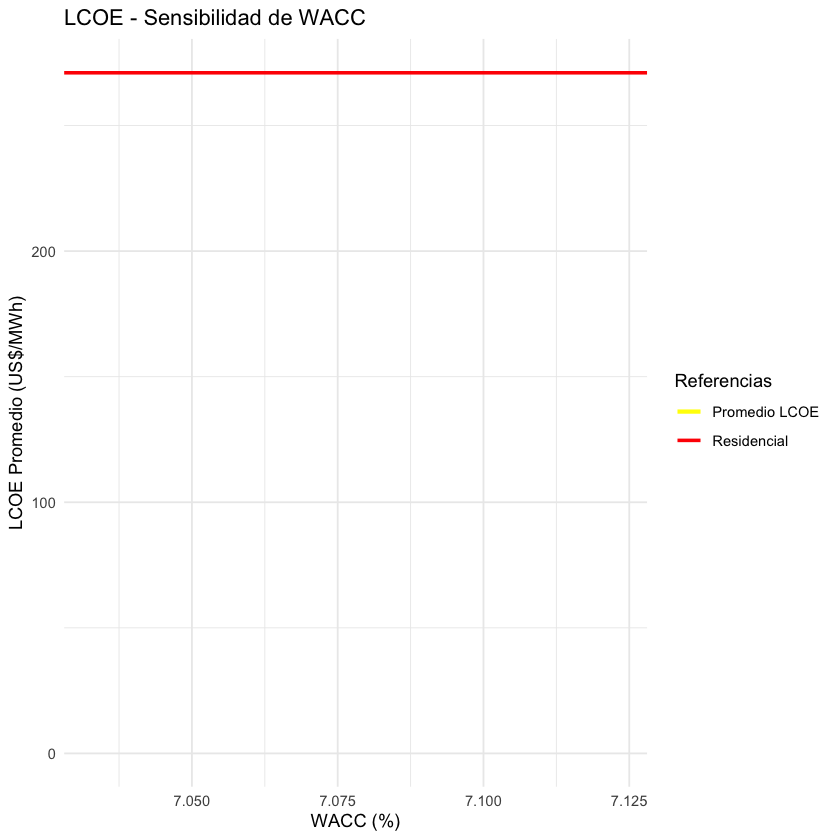

In [12]:
# Ajustar un modelo de regresión lineal a los datos
modelo_LCOE <- lm(LCOE_mean ~ rate, data = LCOE_avg)

# Crear datos para la línea de tendencia basada en la pendiente promedio
LCOE_avg <- LCOE_avg |>
  mutate(LCOE_trend = predict(modelo_LCOE, newdata = LCOE_avg))

# Graficar
# ggplot(LCOE_avg, aes(x = rate * 100, y = LCOE_mean)) +
#   geom_line(color = "blue", size = 1.2) +  # Línea para LCOE promedio
#   geom_line(aes(y = LCOE_trend), color = "Promedio LCOE", linetype = "Promedio LCOE", size = 1.2) +  # Línea tendencia LCOE
#   geom_hline(aes(yintercept = 271, linetype = "Residencial", color = "Residencial"), size = 1) +
#   geom_hline(aes(yintercept = 129, linetype = "Industrial", color = "Industrial"), size = 1) +
#   scale_linetype_manual(name = "Tipo de línea", values = c("Residencial" = "dashed", "Industrial" = "dashed", "Promedio LCOE" = "dashed")) +
#   scale_color_manual(name = "Tipo de línea", values = c("Residencial" = "red", "Industrial" = "green", "Promedio LCOE" = "yellow")) +
#   labs(
#     x = "WACC (%)",
#     y = "LCOE Promedio (US$/MWh)",
#     title = "LCOE-Sensibilidad de WACC "
#   ) +
#   theme_minimal()
# Graficar
ggplot(LCOE_avg, aes(x = rate * 100, y = LCOE_mean)) +
  geom_line(color = "blue", size = 1.2) +  # Línea para LCOE promedio
  geom_line(aes(y = LCOE_trend, linetype = "Promedio LCOE", color = "Promedio LCOE"), size = 1.2) +  # Línea tendencia LCOE
  geom_hline(aes(yintercept = 271, linetype = "Residencial", color = "Residencial"), size = 1) +

  scale_linetype_manual(name = "Referencias", values = c("Residencial" = "solid", "Industrial" = "solid", "Promedio LCOE" = "solid")) +
  scale_color_manual(name = "Referencias", values = c("Residencial" = "red",  "Promedio LCOE" = "yellow")) +
  labs(
    x = "WACC (%)",
    y = "LCOE Promedio (US$/MWh)",
    title = "LCOE - Sensibilidad de WACC"
  ) +
  theme_minimal()

In [13]:
# Calcular la probabilidad de que LCOE_mean sea menor que 271 US$/MWh
probabilidad_menor_residencial <- mean(LCOE_avg$LCOE_mean < 271)

# Mostrar el resultado
print(paste("La probabilidad de que el LCOE sea menor que 271 US$/MWh es:", round(probabilidad_menor_residencial * 100, 2), "%"))


[1] "La probabilidad de que el LCOE sea menor que 271 US$/MWh es: 100 %"


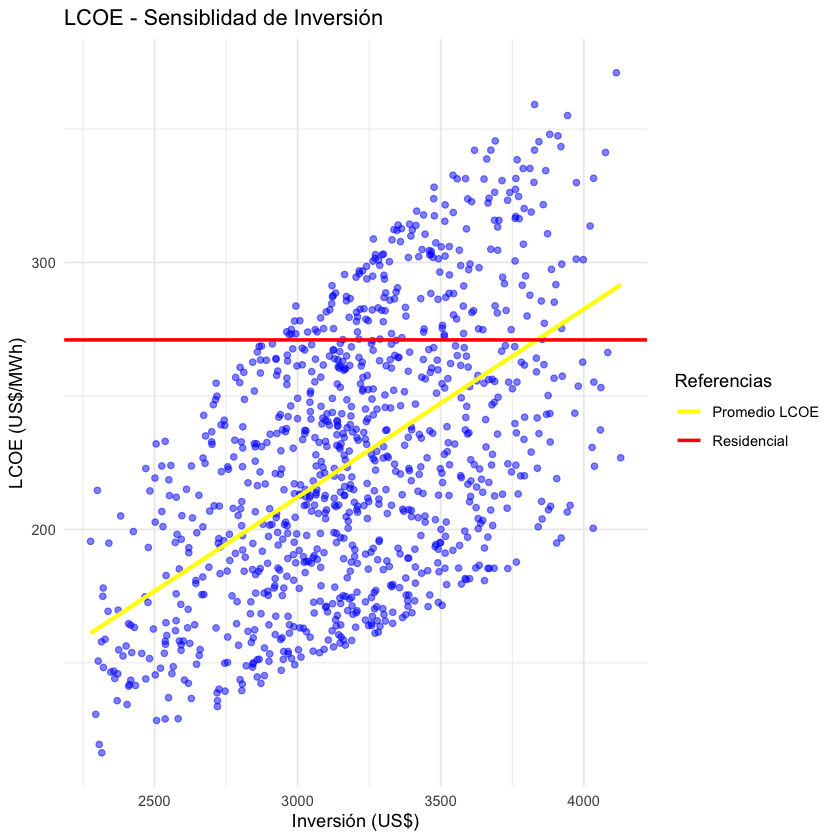

In [14]:
# Ajustar un modelo de regresión lineal a los datos
modelo_LCOE <- lm(LCOE ~ Inv, data = Scenarios)

# Crear datos para la línea de tendencia basada en la pendiente promedio
Scenarios <- Scenarios |>
  mutate(LCOE_trend = predict(modelo_LCOE, newdata = Scenarios))

# Graficar LCOE en función del CAPEX
ggplot(Scenarios, aes(x = Inv, y = LCOE)) +
  geom_point(color = "blue", alpha = 0.5) +  # Puntos individuales
  geom_line(aes(y = LCOE_trend, linetype = "Promedio LCOE", color = "Promedio LCOE"), size = 1.2) +  # Línea tendencia LCOE
  geom_hline(aes(yintercept = 271, linetype = "Residencial", color = "Residencial"), size = 1) +

  scale_linetype_manual(name = "Referencias", values = c("Residencial" = "solid", "Industrial" = "solid", "Promedio LCOE" = "solid")) +
  scale_color_manual(name = "Referencias", values = c("Residencial" = "red", "Industrial" = "green", "Promedio LCOE" = "yellow")) +
  labs(
    x = "Inversión (US$)",
    y = "LCOE (US$/MWh)",
    title = "LCOE - Sensiblidad de Inversión"
  ) +
  theme_minimal()


In [15]:
# Calcular la probabilidad de que LCOE_mean sea menor que 271 US$/MWh
probabilidad_menor_residencial <- mean(LCOE_avg$LCOE_mean < 271)

# Mostrar el resultado
print(paste("La probabilidad de que el LCOE sea menor que 271 US$/MWh es:", round(probabilidad_menor_residencial * 100, 2), "%"))

[1] "La probabilidad de que el LCOE sea menor que 271 US$/MWh es: 100 %"


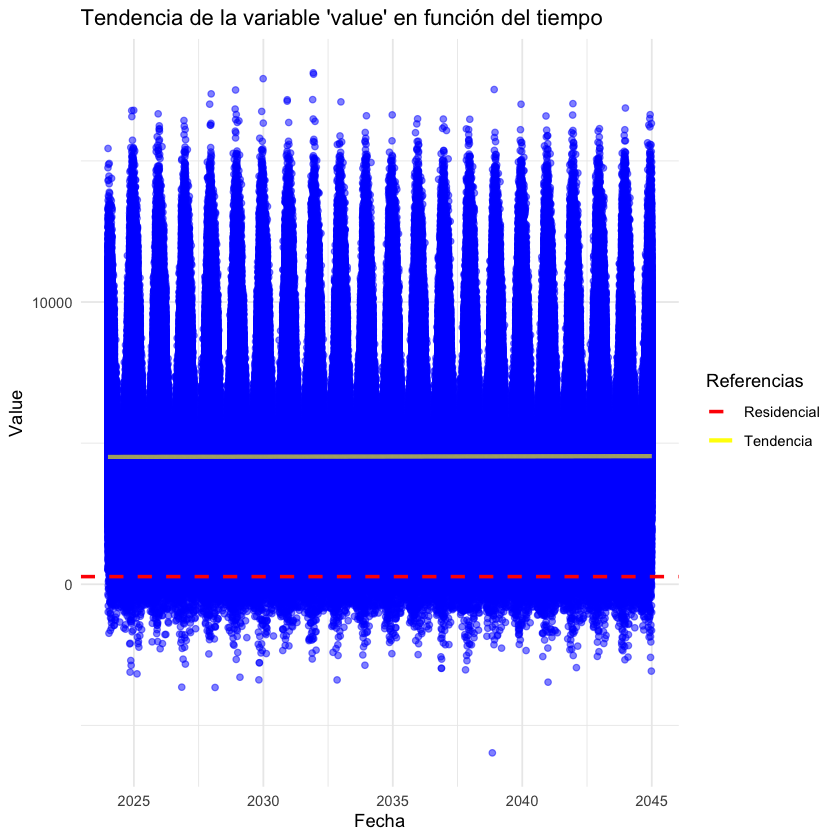

In [16]:
# Cargar librerías necesarias
library(ggplot2)
library(dplyr)

# Cargar el archivo CSV
df <- read.csv("~/GitHub/SOLAR_LCOE_UY/data/raw/RadiationSim2024_2044.csv")

# Convertir la columna de fecha a formato Date
df$date <- as.Date(df$date, format="%Y-%m-%d")

# Convertir fechas a días desde la primera fecha
df$days_since_start <- as.numeric(df$date - min(df$date))

# Ajustar un modelo de regresión lineal
modelo <- lm(value ~ days_since_start, data = df)

# Agregar la tendencia al dataset
df <- df %>%
  mutate(value_trend = predict(modelo, newdata = df))

# Graficar value en función del tiempo con la tendencia
ggplot(df, aes(x = date, y = value)) +
  geom_point(color = "blue", alpha = 0.5) +  # Puntos individuales
  geom_line(aes(y = value_trend, linetype = "Tendencia", color = "Tendencia"), size = 1.2) +  # Línea de tendencia
  geom_hline(aes(yintercept = 271, linetype = "Residencial", color = "Residencial"), size = 1) +
  scale_linetype_manual(name = "Referencias", values = c("Residencial" = "dashed", "Tendencia" = "solid")) +
  scale_color_manual(name = "Referencias", values = c("Residencial" = "red", "Tendencia" = "yellow")) +
  labs(
    x = "Fecha",
    y = "Value",
    title = "Tendencia de la variable 'value' en función del tiempo"
  ) +
  theme_minimal()


Rows: 7671000 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl  (2): value, id
date (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
`summarise()` has grouped output by 'id'. You can override using the `.groups`
argument.


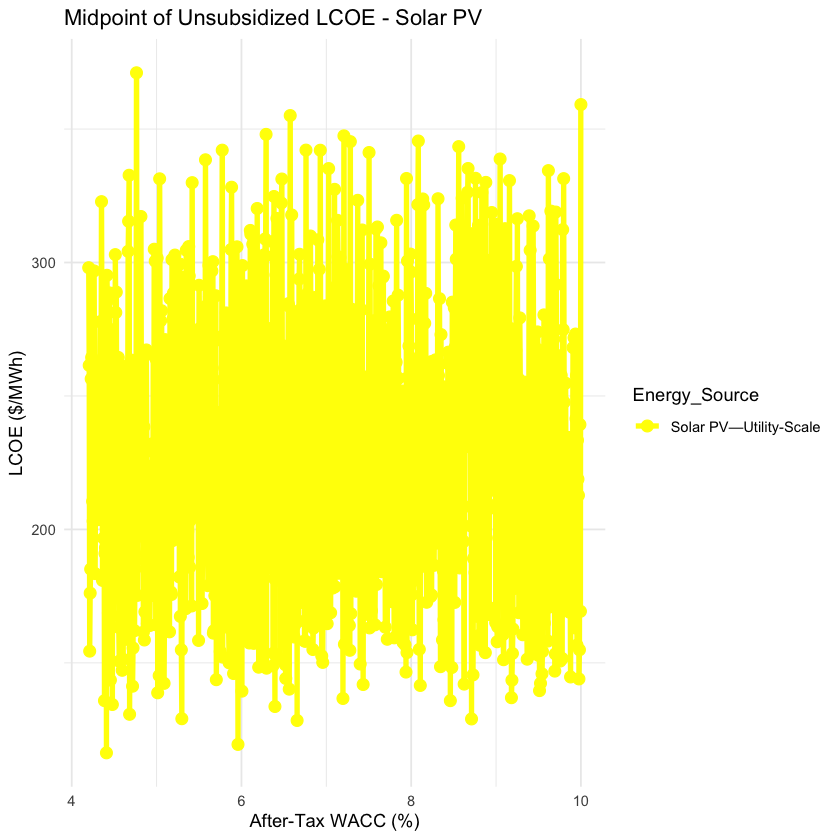

In [17]:
library(ggplot2)
library(dplyr)
library(readr)
library(lubridate)

# Cargar el archivo CSV con radiación solar
DB_rad <- read_csv("~/GitHub/SOLAR_LCOE_UY/data/raw/RadiationSim2024_2044.csv")

# Definir parámetros de Monte Carlo para inversión y tasa de descuento
set.seed(1995)
Par_MonteCarlo <- tibble(
  id = seq(1, 1000),
  inv = rtriangle(1000, 2230, 4150, 3190), # CAPEX
  rate = runif(1000, 0.04, 0.1)  # WACC
)

# Calcular LCOE basado en la radiación solar
Scenarios <- DB_rad |>
  mutate(
    year = year(date),
    Output = (value/1000) * 0.153 * 6.455 * 1  # Cálculo de energía generada
  ) |>
  group_by(id, year) |>
  summarise(yearlyoutput = sum(Output), avg_radiation = mean(value)) |>
  left_join(Par_MonteCarlo, by = "id") |>
  mutate(
    t = year - 2020,
    FDf = yearlyoutput * (1 / (1 + rate)^t)
  ) |>
  summarise(
    Inv = mean(inv),
    VPf = sum(FDf),
    avg_radiation = mean(avg_radiation),
    LCOE_mean = (mean(inv) / sum(FDf)) * 1000,
    LCOE_min = (min(inv) / sum(FDf)) * 1000,
    LCOE_max = (max(inv) / sum(FDf)) * 1000
  )

# Filtrar solo energía solar
lcoe_data <- Scenarios |>
  mutate(IRR_WACC = seq(4.2, 10.0, length.out = n())) |>
  select(IRR_WACC, LCOE_mean) |>
  mutate(Energy_Source = "Solar PV—Utility-Scale")

# Graficar solo energía solar con líneas conectadas
ggplot(lcoe_data, aes(x = IRR_WACC, y = LCOE_mean, color = Energy_Source)) +
  geom_line(size = 1.5) +
  geom_point(size = 3) +
  scale_color_manual(values = c("Solar PV—Utility-Scale" = "yellow")) +
  theme_minimal() +
  labs(
    title = "Midpoint of Unsubsidized LCOE - Solar PV",
    x = "After-Tax WACC (%)",
    y = "LCOE ($/MWh)"
  )


Rows: 7671000 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl  (2): value, id
date (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
`summarise()` has grouped output by 'id'. You can override using the `.groups`
argument.
`geom_smooth()` using formula = 'y ~ x'


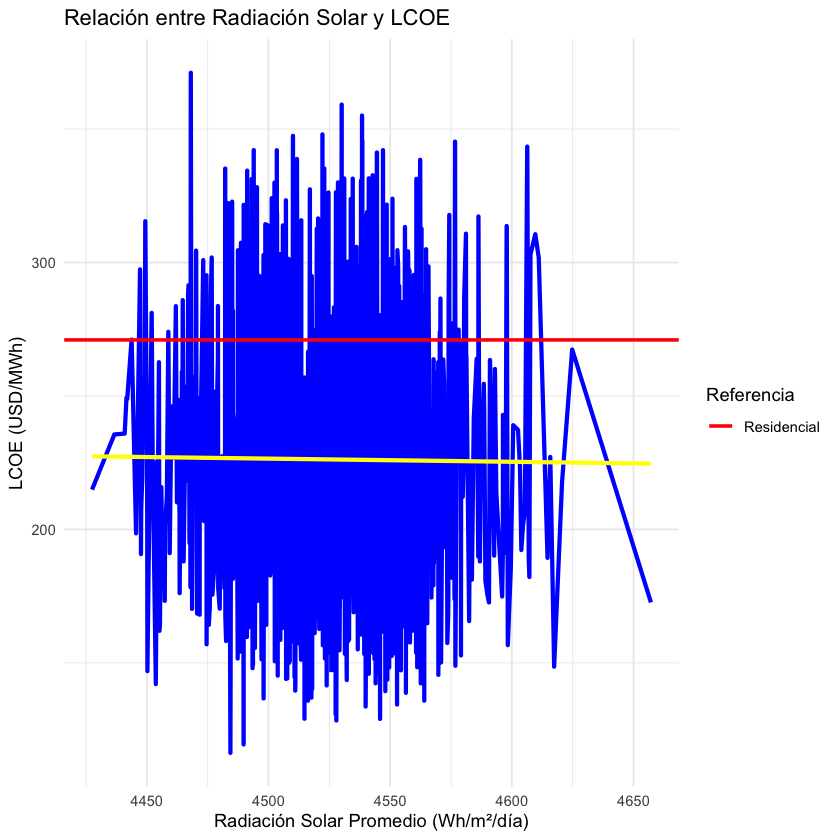

In [18]:
#hacete cargo BFF
# Cargar librerías necesarias
library(ggplot2)
library(dplyr)
library(readr)
library(lubridate)

# Cargar el archivo CSV con radiación solar
DB_rad <- read_csv("~/GitHub/SOLAR_LCOE_UY/data/raw/RadiationSim2024_2044.csv")

# Definir parámetros de Monte Carlo para inversión y tasa de descuento
set.seed(1995)
Par_MonteCarlo <- tibble(
  id = seq(1, 1000),
  inv = rtriangle(1000, 2230, 4150, 3190), # CAPEX
  rate = runif(1000, 0.04, 0.1)  # WACC
)

# Calcular LCOE basado en la radiación solar
Scenarios <- DB_rad |>
  mutate(
    year = year(date),
    Output = (value/1000) * 0.153 * 6.455 * 1  # Cálculo de energía generada
  ) |>
  group_by(id, year) |>
  summarise(yearlyoutput = sum(Output), avg_radiation = mean(value)) |> # Mantener avg_radiation para graficar
  left_join(Par_MonteCarlo, by = "id") |>
  mutate(
    t = year - 2020,
    FDf = yearlyoutput * (1 / (1 + rate)^t)
  ) |>
  summarise(
    Inv = mean(inv),
    VPf = sum(FDf),
    avg_radiation = mean(avg_radiation),  # Conservar la radiación media por escenario
    LCOE_mean = (mean(inv) / sum(FDf)) * 1000,
    LCOE_min = (min(inv) / sum(FDf)) * 1000,
    LCOE_max = (max(inv) / sum(FDf)) * 1000
  )

# Graficar LCOE en función de la radiación solar con líneas y área rellena
ggplot(Scenarios, aes(x = avg_radiation)) +
  geom_ribbon(aes(ymin = LCOE_min, ymax = LCOE_max), fill = "blue", alpha = 0.3) +  # Área de variabilidad del LCOE
  geom_line(aes(y = LCOE_mean), color = "blue", size = 1.2) +  # Línea del LCOE promedio
  geom_smooth(aes(y = LCOE_mean), method = "lm", color = "yellow", se = FALSE, size = 1.2) +  # Línea de tendencia
  geom_hline(aes(yintercept = 271, linetype = "Residencial", color = "Residencial"), size = 1) +

  scale_linetype_manual(name = "Referencia", values = c("Residencial" = "solid", "Industrial" = "solid", "Tendencia" = "solid")) +
  scale_color_manual(name = "Referencia", values = c("Residencial" = "red", "Industrial" = "green", "Tendencia" = "yellow")) +
  labs(
    x = "Radiación Solar Promedio (Wh/m²/día)",
    y = "LCOE (USD/MWh)",
    title = "Relación entre Radiación Solar y LCOE"
  ) +
  theme_minimal()


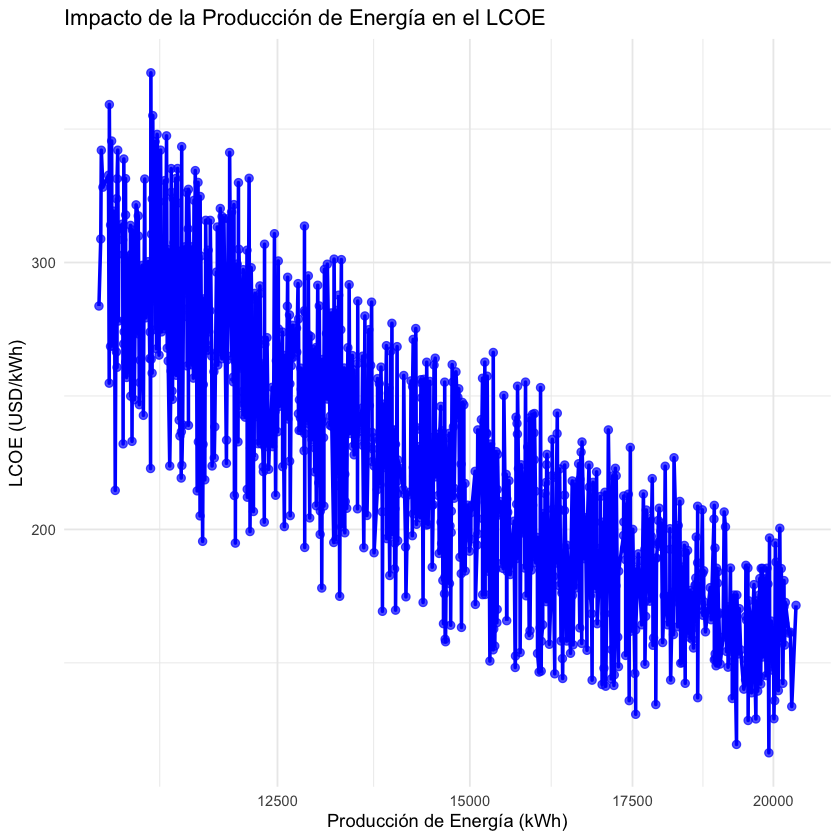

In [19]:
library(ggplot2)
library(dplyr)
library(readr)
library(lubridate)

# Cargar y procesar los datos de radiación solar
Scenarios <- DB_rad |>
  mutate(
    year = year(date),
    Output = (value / 1000) * 0.153 * 6.455 * 1  # Cálculo de energía generada
  ) |>
  group_by(id, year) |>
  summarise(yearlyoutput = sum(Output), avg_radiation = mean(value), .groups = "drop") |>
  left_join(Par_MonteCarlo, by = "id") |>
  mutate(
    t = year - 2020,
    FDf = yearlyoutput * (1 / (1 + rate)^t)
  ) |>
  group_by(id) |>  # <-- Agrupar por id para obtener múltiples valores
  summarise(
    Inv = mean(inv),
    VPf = sum(FDf),  # Flujo de caja descontado acumulado
    avg_radiation = mean(avg_radiation, na.rm = TRUE),
    LCOE_mean = (mean(inv) / sum(FDf)) * 1000,  # LCOE para cada escenario
    .groups = "drop"
  )

# Graficar con escala logarítmica en X para mejor visualización
ggplot(Scenarios, aes(x = VPf, y = LCOE_mean)) +
  geom_line(color = "blue", size = 1) +  # Línea de impacto de producción de energía
  geom_point(color = "blue", size = 2, alpha = 0.7) +  # Puntos de datos individuales
  scale_x_log10() +  # Escala logarítmica en el eje X
  labs(
    x = "Producción de Energía (kWh)",
    y = "LCOE (USD/kWh)",
    title = "Impacto de la Producción de Energía en el LCOE"
  ) +
  theme_minimal()



Rows: 7671000 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl  (2): value, id
date (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


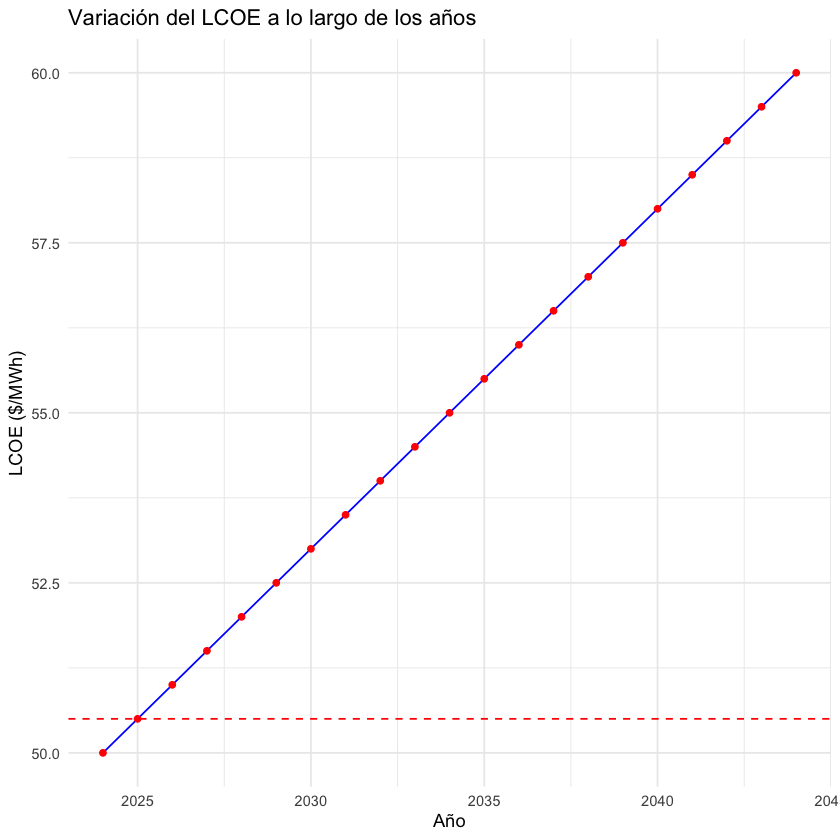

In [20]:
#Por mes y por año
# Cargar librerías necesarias
library(tidyverse)
library(lubridate)

# Cargar datos de radiación
DB_rad <- read_csv("~/GitHub/SOLAR_LCOE_UY/data/raw/RadiationSim2024_2044.csv")

# Filtrar datos del año 2025 y agregar columna de mes
df_2025 <- DB_rad %>%
  filter(year(date) == 2025) %>%
  mutate(month = month(date, label = TRUE))

# Agrupar por mes y calcular la radiación promedio
monthly_radiation <- df_2025 %>%
  group_by(month) %>%
  summarise(avg_radiation = mean(value, na.rm = TRUE))

# Simular los valores de LCOE para los años 2024 y 2025 (si no están en el dataset)
LCOE_data <- tibble(
  year = 2024:2044,
  LCOE = seq(50, 60, length.out = 21) # Simulación lineal
)

# Extraer los valores de LCOE de 2024 y 2025
LCOE_2024 <- LCOE_data %>% filter(year == 2024) %>% pull(LCOE)
LCOE_2025 <- LCOE_data %>% filter(year == 2025) %>% pull(LCOE)

# Calcular la variación porcentual del LCOE
LCOE_variation <- ((LCOE_2025 - LCOE_2024) / LCOE_2024) * 100

# Graficar la variación del LCOE a lo largo del tiempo
ggplot(LCOE_data, aes(x = year, y = LCOE)) +
  geom_line(color = "blue") +
  geom_point(color = "red") +
  geom_hline(yintercept = LCOE_2025, linetype = "dashed", color = "red") +
  labs(title = "Variación del LCOE a lo largo de los años",
       x = "Año", y = "LCOE ($/MWh)") +
  theme_minimal()



Rows: 7671000 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl  (2): value, id
date (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# A tibble: 12 × 2
   month avg_radiation
   <ord>         <dbl>
 1 Jan           6766.
 2 Feb           6122.
 3 Mar           5078.
 4 Apr           3668.
 5 May           2549.
 6 Jun           2229.
 7 Jul           2293.
 8 Aug           3215.
 9 Sep           3622.
10 Oct           5137.
11 Nov           6494.
12 Dec           7184.


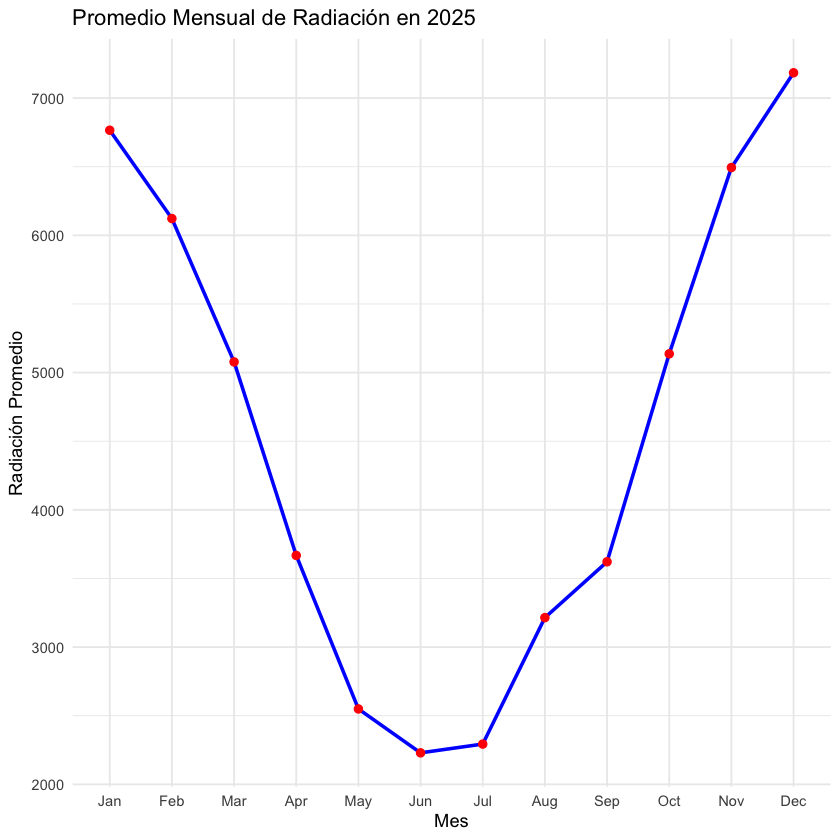

In [21]:
# Cargar librerías necesarias
library(tidyverse)
library(lubridate)

# Cargar los datos de radiación
DB_rad <- read_csv("~/GitHub/SOLAR_LCOE_UY/data/raw/RadiationSim2024_2044.csv")

# Convertir la columna 'date' a formato de fecha
DB_rad <- DB_rad %>%
  mutate(date = as.Date(date, format="%Y-%m-%d"))

# Filtrar datos del año 2025
df_2025 <- DB_rad %>%
  filter(year(date) == 2025) %>%
  mutate(month = month(date, label = TRUE))

# Calcular el promedio mensual de radiación
monthly_radiation <- df_2025 %>%
  group_by(month) %>%
  summarise(avg_radiation = mean(value, na.rm = TRUE))

# Mostrar los resultados
print(monthly_radiation)

# Graficar la radiación mensual en 2025
ggplot(monthly_radiation, aes(x = month, y = avg_radiation, group = 1)) +
  geom_line(color = "blue", size = 1) +
  geom_point(color = "red", size = 2) +
  labs(title = "Promedio Mensual de Radiación en 2025",
       x = "Mes", y = "Radiación Promedio") +
  theme_minimal()



In [22]:
# Cargar librerías necesarias
library(tidyverse)
library(lubridate)
library(ggplot2)
library(triangle) # Para distribución triangular

# Cargar los datos de radiación
DB_rad <- read_csv("~/GitHub/SOLAR_LCOE_UY/data/raw/RadiationSim2024_2044.csv")

# Convertir la columna 'date' a formato de fecha
DB_rad <- DB_rad %>%
  mutate(date = as.Date(date, format="%Y-%m-%d"))

# Filtrar datos del año 2025 y calcular promedio mensual de radiación
df_2025 <- DB_rad %>%
  filter(year(date) == 2025) %>%
  mutate(month = month(date, label = TRUE))

monthly_radiation <- df_2025 %>%
  group_by(month) %>%
  summarise(avg_radiation = mean(value, na.rm = TRUE))

# 🔹 Simulación Monte Carlo para calcular LCOE
set.seed(1995)

Par_MonteCarlo <- tibble(
  id = seq(1, 1000),
  inv = rtriangle(1000, 2230, 4150, 3190), # CAPEX
  rate = runif(1000, 0.04, 0.1) # WACC
)

# Procesar los escenarios
Scenarios <- DB_rad %>%
  group_by(id = rep(1:1000, length.out = n())) %>% # Simulación para 1000 escenarios
  mutate(year = year(date),
         Output = (value / 1000) * 0.153 * 6.455 * 1) %>%
  group_by(id, year) %>%
  summarise(yearlyoutput = sum(Output), .groups = "drop") %>%
  left_join(Par_MonteCarlo, by = "id") %>%
  mutate(t = year - 2020,
         FDf = yearlyoutput * (1 / (1 + rate) ^ t)) %>%
  group_by(id) %>%
  summarise(Inv = mean(inv),
            VPf = sum(FDf),
            LCOE = (Inv / VPf) * 1000, .groups = "drop")


Rows: 7671000 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl  (2): value, id
date (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [30]:
head(Scenarios)

id,Inv,VPf,LCOE
<int>,<dbl>,<dbl>,<dbl>
1,3634.097,12118.95,299.8689
2,3570.097,13639.64,261.7442
3,3054.285,19648.28,155.4479
4,2882.879,16503.40,174.6840
5,3247.155,17570.00,184.8124
6,3446.671,13576.38,253.8726


In [29]:
# Instalar una sola vez
install.packages("lubridate")

# Cargar librerías
library(dplyr)
library(lubridate)

# Verificamos y convertimos a clase Date si es necesario
Scenarios <- Scenarios %>%
  mutate(
    date = as.Date(date),   # Si viene en formato "YYYY-MM-DD"
    year = year(date)
  )


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



ERROR: [1m[33mError[39m in `mutate()`:[22m
[1m[22m[36mℹ[39m In argument: `date = as.Date(date)`.
[1mCaused by error in `as.Date.default()`:[22m
[33m![39m incapaz de convertir 'date' a clase “Date”


In [27]:
Scenarios_2025 <- Scenarios %>% filter(year(date) == 2025)
# Calcular el LCOE promedio para 2025
LCOE_2025 <- mean(Scenarios$LCOE, na.rm = TRUE)

# 🔹 Crear dataframe para graficar
plot_data <- tibble(
  avg_radiation = monthly_radiation$avg_radiation, # Radiación Promedio por mes
  LCOE = Scenarios_2025 # LCOE constante en función de la radiación
)

# 🔹 Graficar LCOE en función del promedio de radiación
# ggplot(plot_data, aes(x = avg_radiation, y = LCOE)) +
#   geom_point(color = "red", size = 3) +
#   geom_smooth(method = "lm", color = "blue", se = FALSE) +
#   labs(title = "Relación entre LCOE y Promedio de Radiación en 2025",
#        x = "Radiación Promedio (kWh/m²)",
#        y = "LCOE ($/MWh)") +
#   theme_minimal()
# 🔹 Graficar LCOE en función del promedio de radiación
# Convertir la columna date a Date antes de usar year()
Scenarios$date <- as.Date(Scenarios$date)

ggplot(plot_data, aes(x = avg_radiation, y = LCOE)) +
  geom_point(color = "red", size = 3) +
  geom_smooth(method = "lm", color = "blue", se = FALSE) +
  labs(title = "Relación entre LCOE y Promedio de Radiación en 2025",
       x = "Radiación Promedio (kWh/m²)",
       y = "LCOE ($/MWh)") +
  theme_minimal()


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



ERROR: [1m[33mError[39m in `mutate()`:[22m
[1m[22m[36mℹ[39m In argument: `date = as.Date(date)`.
[1mCaused by error in `as.Date.default()`:[22m
[33m![39m incapaz de convertir 'date' a clase “Date”


In [31]:
library(tidyverse)
library(lubridate)

# Cargar los datos correctamente y transformar explícitamente la columna 'date'
DB_rad <- read_csv("~/GitHub/SOLAR_LCOE_UY/data/raw/RadiationSim2024_2044.csv") %>%
  mutate(date = as.Date(date))

# Ejemplo (debes ajustar según cómo se genere realmente Scenarios):
# Scenarios debe tener al menos: año (year) y LCOE
# Ejemplo para generar Scenarios (solo si no lo tienes previamente):
# Scenarios <- tibble(year = 2024:2044, LCOE = runif(21, 50, 100))

# Calcula LCOE promedio anual (si ya existe no ejecutes esta parte)
LCOE_anual <- Scenarios %>%
  group_by(year) %>%
  summarise(LCOE_promedio = mean(LCOE, na.rm = TRUE))

# Radiación promedio mensual y luego anual
Radiacion_anual <- DB_rad %>%
  mutate(year = year(date), mes = month(date)) %>%
  group_by(year, mes) %>%
  summarise(radiacion_promedio_mes = mean(value, na.rm = TRUE)) %>%
  group_by(year) %>%
  summarise(radiacion_promedio_anual = mean(radiacion_promedio_mes, na.rm = TRUE))

# Unión de datasets por año
data_plot <- inner_join(LCOE_anual, Radiacion_anual, by = "year")

# Gráfico final
ggplot(data_plot, aes(x = radiacion_promedio_anual, y = LCOE_promedio)) +
  geom_point(size = 3, color = "blue") +
  geom_smooth(method = "lm", color = "red", se = FALSE) +
  labs(x = "Radiación promedio anual (kWh/m²)",
       y = "LCOE promedio anual (USD/MWh)",
       title = "Relación entre Radiación promedio anual y LCOE promedio anual") +
  theme_minimal()




Rows: 7671000 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl  (2): value, id
date (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


ERROR: [1m[33mError[39m in `group_by()`:[22m
[1m[22m[33m![39m Must group by variables found in `.data`.
[31m✖[39m Column `year` is not found.


In [32]:
# Calcular la probabilidad de que LCOE_mean sea menor que 271 US$/MWh
probabilidad_menor_residencial <- mean(LCOE_avg$LCOE_mean < 271)

# Mostrar el resultado
print(paste("La probabilidad de que el LCOE sea menor que 271 US$/MWh es:", round(probabilidad_menor_residencial * 100, 2), "%"))

[1] "La probabilidad de que el LCOE sea menor que 271 US$/MWh es: 100 %"


[1] "date"  "value" "id"

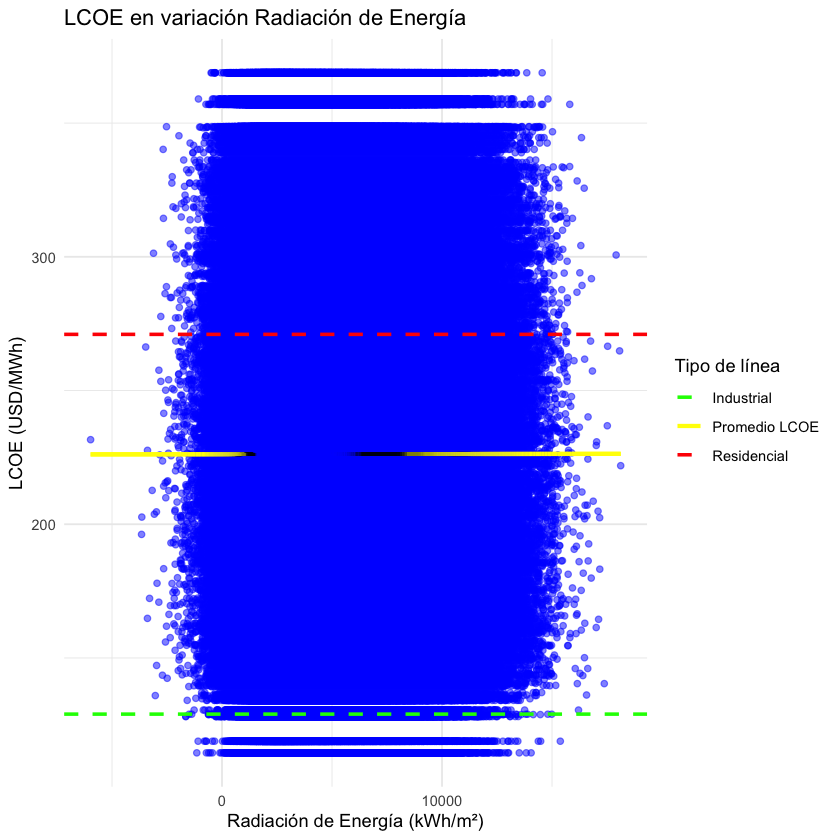

In [33]:
# VER ENZO, Dale que sos vos.
library(ggplot2)
library(dplyr)


colnames(DB_rad)
Scenarios <- Scenarios |>
  left_join(DB_rad |> select(id, date, value), by = "id")
modelo_LCOE <- lm(LCOE ~ value, data = Scenarios)

# Crear datos para la línea de tendencia basada en la pendiente promedio
Scenarios <- Scenarios |>
  mutate(LCOE_trend = predict(modelo_LCOE, newdata = Scenarios))

# Filtrar valores negativos de LCOE
Scenarios <- Scenarios |> filter(LCOE >= 0)

# Graficar LCOE en función de la radiación de energía
ggplot(Scenarios, aes(x = value, y = LCOE)) +
  geom_point(color = "blue", alpha = 0.5) +  # Puntos individuales
  geom_line(aes(y = LCOE_trend), color = "yellow", size = 1.2) +  # Línea de tendencia en amarillo
  geom_line(aes(y = LCOE_trend, linetype = "Promedio LCOE", color = "Promedio LCOE"), size = 1.2) +  # Línea tendencia LCOE
  geom_hline(aes(yintercept = 271, linetype = "Residencial", color = "Residencial"), size = 1) +
  geom_hline(aes(yintercept = 129, linetype = "Industrial", color = "Industrial"), size = 1) +
  scale_linetype_manual(name = "Tipo de línea", values = c("Residencial" = "dashed", "Industrial" = "dashed", "Promedio LCOE" = "solid")) +
  scale_color_manual(name = "Tipo de línea", values = c("Residencial" = "red", "Industrial" = "green", "Promedio LCOE" = "yellow")) +
  labs(
    x = "Radiación de Energía (kWh/m²)",
    y = "LCOE (USD/MWh)",
    title = "LCOE en variación Radiación de Energía"
  ) +
  theme_minimal()


In [34]:
summary(Scenarios)

       id              Inv            VPf             LCOE      
 Min.   :   1.0   Min.   :2277   Min.   :10590   Min.   :114.5  
 1st Qu.: 250.8   1st Qu.:2946   1st Qu.:12221   1st Qu.:186.4  
 Median : 500.5   Median :3190   Median :14325   Median :222.6  
 Mean   : 500.5   Mean   :3201   Mean   :14659   Mean   :226.2  
 3rd Qu.: 750.2   3rd Qu.:3490   3rd Qu.:16728   3rd Qu.:262.7  
 Max.   :1000.0   Max.   :4129   Max.   :20373   Max.   :368.8  
      date                value         LCOE_trend   
 Min.   :2024-01-01   Min.   :-5973   Min.   :226.1  
 1st Qu.:2029-04-01   1st Qu.: 2675   1st Qu.:226.2  
 Median :2034-07-02   Median : 4062   Median :226.2  
 Mean   :2034-07-02   Mean   : 4525   Mean   :226.2  
 3rd Qu.:2039-10-02   3rd Qu.: 6076   3rd Qu.:226.2  
 Max.   :2044-12-31   Max.   :18122   Max.   :226.3  

In [35]:
cor(Scenarios$value, Scenarios$LCOE, use = "complete.obs")


[1] 0.0003739732

In [36]:
summary(modelo_LCOE)


Call:
lm(formula = LCOE ~ value, data = Scenarios)

Residuals:
     Min       1Q   Median       3Q      Max 
-111.768  -39.812   -3.613   36.489  142.639 

Coefficients:
             Estimate Std. Error  t value Pr(>|t|)    
(Intercept) 2.262e+02  3.942e-02 5737.636   <2e-16 ***
value       8.002e-06  7.726e-06    1.036      0.3    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 50.42 on 7670998 degrees of freedom
Multiple R-squared:  1.399e-07,	Adjusted R-squared:  9.495e-09 
F-statistic: 1.073 on 1 and 7670998 DF,  p-value: 0.3003


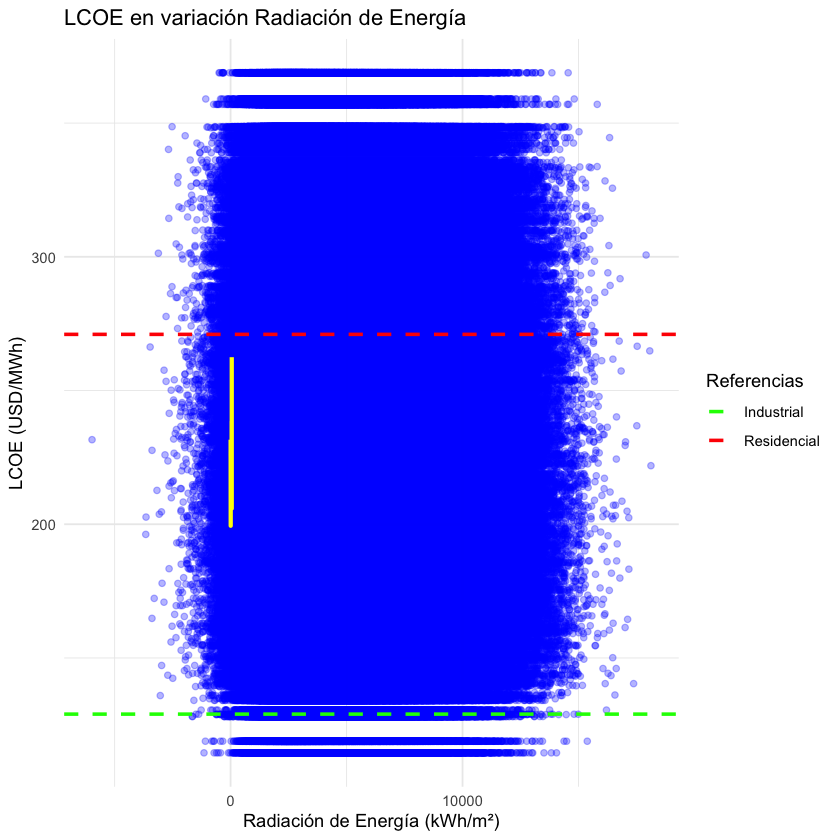

In [37]:
library(dplyr)
library(ggplot2)

# Agrupar por intervalos de radiación de energía y calcular el promedio de LCOE
Scenarios_avg <- Scenarios %>%
  group_by(value_bin = cut(value, breaks = 50)) %>%  # Crea 50 intervalos de radiación
  summarise(LCOE_mean = mean(LCOE, na.rm = TRUE))

# Graficar
ggplot(Scenarios, aes(x = value, y = LCOE)) +
  geom_point(color = "blue", alpha = 0.3) +  # Simulaciones Montecarlo
  geom_line(data = Scenarios_avg, aes(x = as.numeric(value_bin), y = LCOE_mean),
            color = "yellow", size = 1.2) +  # Promedio de LCOE por intervalos de radiación
  geom_hline(aes(yintercept = 271, linetype = "Residencial", color = "Residencial"), size = 1) +
  geom_hline(aes(yintercept = 129, linetype = "Industrial", color = "Industrial"), size = 1) +
  scale_linetype_manual(name = "Referencias", values = c("Residencial" = "dashed", "Industrial" = "dashed")) +
  scale_color_manual(name = "Referencias", values = c("Residencial" = "red", "Industrial" = "green")) +
  labs(x = "Radiación de Energía (kWh/m²)", y = "LCOE (USD/MWh)",
       title = "LCOE en variación Radiación de Energía") +
  theme_minimal()


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  -5973    2675    4062    4525    6076   18122 

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
    0.062  2679.258  4065.489  4531.444  6078.969 18121.907 

ERROR: [1m[33mError[39m in `arrange()`:[22m
[1m[22m[36mℹ[39m In argument: `..1 = yearlyoutput`.
[1mCaused by error:[22m
[33m![39m objeto 'yearlyoutput' no encontrado


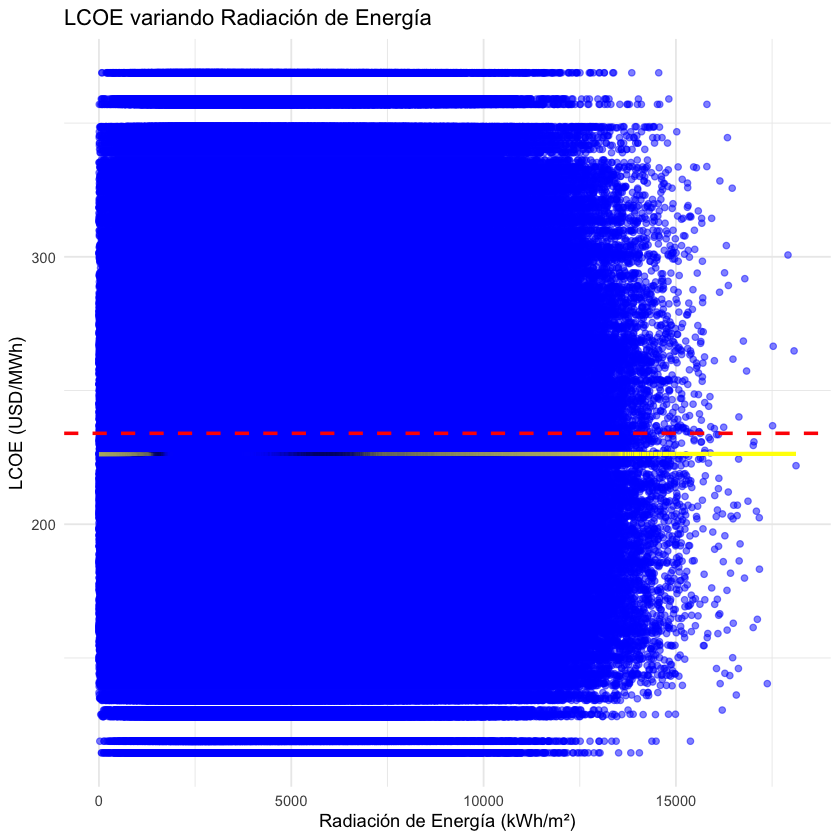

In [38]:
summary(Scenarios$value)
Scenarios <- Scenarios |>
  filter(value >= 0)  # Eliminar valores negativos de radiación
summary(Scenarios$value)
# Graficar LCOE en función de la radiación de energía
ggplot(Scenarios, aes(x = value, y = LCOE)) +
  geom_point(color = "blue", alpha = 0.5) +  # Puntos individuales
  geom_line(aes(y = LCOE_trend), color = "yellow", size = 1.2) +  # Línea de tendencia en amarillo
  geom_hline(yintercept = 0.234 * 1000, linetype = "dashed", color = "red", size = 1) +  # Línea referencia Residencial
  labs(
    x = "Radiación de Energía (kWh/m²)",
    y = "LCOE (USD/MWh)",
    title = "LCOE variando Radiación de Energía"
  ) +
  theme_minimal()
# Ordenar los datos por Energy Production para evitar líneas desordenadas
Scenarios <- Scenarios |> arrange(yearlyoutput)

# Graficar la relación entre Energy Production y LCOE como una línea
ggplot(Scenarios, aes(x = yearlyoutput, y = LCOE)) +
  geom_line(color = "blue", size = 1.2) +  # Línea azul
  labs(
    x = "Energy Production (MWh)",
    y = "LCOE (USD/kWh)",
    title = "Impacto de Energy Production en LCOE"
  ) +
  theme_minimal()



In [39]:
# Ordenar los datos por Energy Production para evitar líneas desordenadas
Scenarios <- Scenarios |> arrange(yearlyoutput)

# Graficar la relación entre Energy Production y LCOE como una línea
ggplot(Scenarios, aes(x = yearlyoutput, y = LCOE)) +
  geom_line(color = "blue", size = 1.2) +  # Línea azul
  labs(
    x = "Energy Production (MWh)",
    y = "LCOE (USD/kWh)",
    title = "Impacto de Energy Production en LCOE"
  ) +
  theme_minimal()



ERROR: [1m[33mError[39m in `arrange()`:[22m
[1m[22m[36mℹ[39m In argument: `..1 = yearlyoutput`.
[1mCaused by error:[22m
[33m![39m objeto 'yearlyoutput' no encontrado


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Rows: 7671000 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl  (2): value, id
date (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Adjuntando el paquete: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


`geom_smooth()` using formula = 'y ~ x'


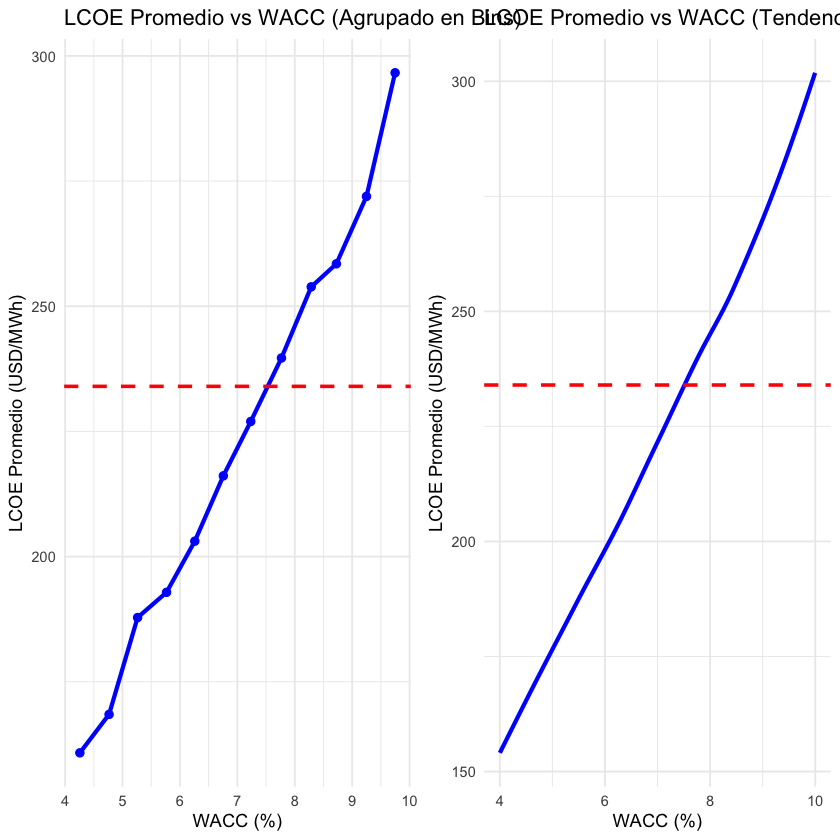

In [40]:
install.packages("gridExtra")

library(tidyverse)
library(triangle)

# Set seed for reproducibility
set.seed(999)

# Monte Carlo Simulation Parameters
Par_MonteCarlo <- tibble(
  id = seq(1, 1000),
  inv = rtriangle(1000, 2230, 4150, 3190),  # CAPEX
  rate = runif(1000, 0.04, 0.1)  # WACC
)

# Load Radiation Data
DB_rad <- read_csv("~/GitHub/SOLAR_LCOE_UY/data/raw/RadiationSim2024_2044.csv")

# Compute Scenarios
Scenarios <- DB_rad |>
  group_by(id) |>
  mutate(
    year = year(date),
    Output = (value / 1000) * 0.153 * 6.455 * 1
  ) |>
  group_by(id, year) |>
  summarise(yearlyoutput = sum(Output), .groups = "drop") |>
  left_join(Par_MonteCarlo, by = "id") |>
  mutate(
    t = year - 2020,
    FDf = yearlyoutput * (1 / (1 + rate) ^ t)
  ) |>
  group_by(id, rate) |>
  summarise(
    Inv = mean(inv),
    VPf = sum(FDf),
    .groups = "drop"
  ) |>
  mutate(LCOE = (Inv / VPf) * 1000)

# Solución 1: Agrupar WACC en intervalos discretos (bins)
LCOE_avg_bins <- Scenarios |>
  mutate(rate_bin = cut(rate, breaks = seq(0.04, 0.1, by = 0.005), include.lowest = TRUE, labels = FALSE)) |>
  group_by(rate_bin) |>
  summarise(WACC = mean(rate) * 100, LCOE_mean = mean(LCOE), .groups = "drop") |>
  arrange(WACC)

# Gráfico 1: Solución con WACC agrupado en bins
p1 <- ggplot(LCOE_avg_bins, aes(x = WACC, y = LCOE_mean)) +
  geom_line(color = "blue", size = 1.2) +
  geom_point(color = "blue", size = 2) +
  geom_hline(yintercept = 0.234 * 1000, linetype = "dashed", color = "red", size = 1) +
  labs(
    x = "WACC (%)",
    y = "LCOE Promedio (USD/MWh)",
    title = "LCOE Promedio vs WACC (Agrupado en Bins)"
  ) +
  theme_minimal()

# Gráfico 2: Solución con suavización de tendencia (loess)
p2 <- ggplot(Scenarios, aes(x = rate * 100, y = LCOE)) +
  geom_smooth(method = "loess", color = "blue", size = 1.2, se = FALSE) +
  geom_hline(yintercept = 0.234 * 1000, linetype = "dashed", color = "red", size = 1) +
  labs(
    x = "WACC (%)",
    y = "LCOE Promedio (USD/MWh)",
    title = "LCOE Promedio vs WACC (Tendencia Suavizada)"
  ) +
  theme_minimal()

# Mostrar ambos gráficos
library(gridExtra)
grid.arrange(p1, p2, ncol = 2)


## Sensiblidad del LCOE

In [41]:

install.packages("sensitivity", dependencies = TRUE, repos = "http://cran.rstudio.com/")
library(ggplot2)
library(sensitivity)
install.packages("randtoolbox", dependencies = TRUE)
library(randtoolbox)



also installing the dependencies ‘nloptr’, ‘pbkrtest’, ‘lme4’, ‘car’, ‘rstatix’, ‘ggpubr’, ‘mc2d’


Warning message in install.packages("sensitivity", dependencies = TRUE, repos = "http://cran.rstudio.com/"):
“installation of package ‘nloptr’ had non-zero exit status”
Warning message in install.packages("sensitivity", dependencies = TRUE, repos = "http://cran.rstudio.com/"):
“installation of package ‘lme4’ had non-zero exit status”
Warning message in install.packages("sensitivity", dependencies = TRUE, repos = "http://cran.rstudio.com/"):
“installation of package ‘pbkrtest’ had non-zero exit status”
Warning message in install.packages("sensitivity", dependencies = TRUE, repos = "http://cran.rstudio.com/"):
“installation of package ‘car’ had non-zero exit status”
Warning message in install.packages("sensitivity", dependencies = TRUE, repos = "http://cran.rstudio.com/"):
“installation of package ‘rstatix’ had non-zero exit status”
Warning message in install.packages("sensitivity", depend

In [42]:
# Cargar librerías necesarias
library(sensitivity)
library(ggplot2)
library(dplyr)

# Función para calcular el LCOE
calcular_lcoe <- function(capital_cost, operating_cost, energy_production, discount_rate, lifetime) {
  discount_rate <- discount_rate / 100  # Convertir porcentaje a decimal
  num <- capital_cost + operating_cost * sum(1 / ((1 + discount_rate)^(1:lifetime)))
  denom <- energy_production * sum(1 / ((1 + discount_rate)^(1:lifetime)))
  return(num / denom)
}

# Definir el problema para el análisis de sensibilidad
problem <- list(
  factors = c("Capital Cost", "Operating Cost", "Energy Production", "Discount Rate", "Lifetime"),
  n = 5,
  xmin = c(500, 5, 1000, 4, 15),
  xmax = c(5000, 50, 20000, 10, 25)
)

# Generar muestras usando Sobol (1024 para evitar advertencias)
set.seed(123)  # Para reproducibilidad
param_values <- data.frame(
  capital_cost = runif(1024, min = problem$xmin[1], max = problem$xmax[1]),
  operating_cost = runif(1024, min = problem$xmin[2], max = problem$xmax[2]),
  energy_production = runif(1024, min = problem$xmin[3], max = problem$xmax[3]),
  discount_rate = runif(1024, min = problem$xmin[4], max = problem$xmax[4]),
  lifetime = runif(1024, min = problem$xmin[5], max = problem$xmax[5])
)

# Evaluar el modelo en las muestras
Y <- apply(param_values, 1, function(params) calcular_lcoe(params[1], params[2], params[3], params[4], params[5]))

# Realizar el análisis de sensibilidad de Sobol
sobol_result <- sobol(model = NULL, X1 = param_values, X2 = param_values, y = Y, order = 1, nboot = 100)

# Extraer contribución de la varianza
S1_percent <- sobol_result$S[, "original"] * 100
ST_percent <- sobol_result$T[, "original"] * 100

# Determinar la variable con mayor impacto
max_index <- which.max(ST_percent)
max_var <- problem$factors[max_index]
max_contribution <- ST_percent[max_index]

# Imprimir resultados
cat("\n🔹 Análisis de Sensibilidad de Sobol - Contribución de la Varianza al LCOE:\n")
for (i in seq_along(problem$factors)) {
  cat(sprintf("%s: %.2f%% (S1), %.2f%% (ST)\n", problem$factors[i], S1_percent[i], ST_percent[i]))
}

cat(sprintf("\n✅ La variable con mayor impacto en el LCOE es **%s** con una contribución del **%.2f%%**.\n",
            max_var, max_contribution))

# 📊 Gráfico de sensibilidad
sensibilidad_df <- data.frame(Variable = problem$factors, ST_Percent = ST_percent)

ggplot(sensibilidad_df, aes(x = reorder(Variable, ST_Percent), y = ST_Percent)) +
  geom_bar(stat = "identity", fill = "skyblue", color = "black") +
  geom_text(aes(label = sprintf("%.2f%%", ST_Percent)), vjust = -0.5, size = 5, fontface = "bold") +
  labs(
    title = "Análisis de Sensibilidad del LCOE",
    x = "Variables de Entrada del LCOE",
    y = "Contribución a la Varianza (%)"
  ) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 20, hjust = 1))



ERROR: Error in sobol(model = NULL, X1 = param_values, X2 = param_values, y = Y, : los argumentos no fueron usados (model = NULL, X1 = param_values, X2 = param_values, y = Y, order = 1, nboot = 100)


Warning message in sobol(n = 1024, dim = problem$num_vars, scrambling = 2, seed = 1234):
“scrambling is currently disabled.”


[1] "All values of t are equal to  1 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to  1 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to  1 \n Cannot calculate confidence intervals"

🔹 Análisis de Sensibilidad de Sobol - Contribución de la Varianza al LCOE:
Capital Cost: 100.00% (S1), -0.00% (ST)
Energy Production: 100.00% (S1), -0.00% (ST)
Discount Rate: 100.00% (S1), -0.00% (ST)

✅ La variable con mayor impacto en el LCOE es **Capital Cost** con una contribución del **-0.00%**.


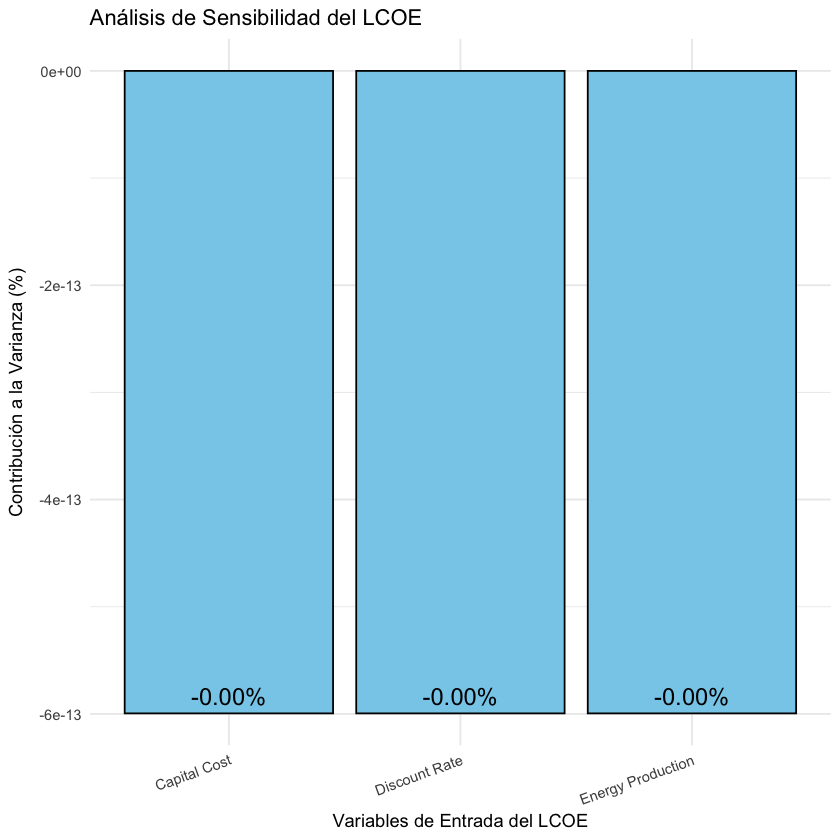

In [43]:
# Cargar librerías necesarias
library(ggplot2)
library(sensitivity)
library(randtoolbox)

# Función para calcular el LCOE
calcular_lcoe <- function(X) {
  capital_cost <- X[, 1]
  energy_production <- X[, 2]
  discount_rate <- X[, 3] / 100  # Convertir a decimal

  lifetime <- 20  # Lifetime fijo
  operating_cost <- capital_cost * 0.01  # Operating Cost = 1% del CAPEX

  num <- capital_cost + operating_cost * sum(1 / ((1 + discount_rate)^(1:lifetime)))
  denom <- energy_production * sum(1 / ((1 + discount_rate)^(1:lifetime)))

  return(num / denom)
}

# Definir el problema para el análisis de sensibilidad
problem <- list(
  num_vars = 3,  # Solo tres variables
  names = c("Capital Cost", "Energy Production", "Discount Rate"),
  bounds = matrix(c(500, 5000,   # Capital Cost
                    1000, 20000, # Energy Production
                    4, 10),      # Discount Rate (WACC)
                  ncol = 2, byrow = TRUE)
)

# Generar dos conjuntos de muestras de Sobol
X1 <- sobol(n = 1024, dim = problem$num_vars, init = TRUE)
X2 <- sobol(n = 1024, dim = problem$num_vars, scrambling = 2, seed = 1234)

# Escalar los parámetros a los valores dentro de los límites
for (i in 1:problem$num_vars) {
  X1[, i] <- problem$bounds[i, 1] + X1[, i] * (problem$bounds[i, 2] - problem$bounds[i, 1])
  X2[, i] <- problem$bounds[i, 1] + X2[, i] * (problem$bounds[i, 2] - problem$bounds[i, 1])
}

# ⚠️ CAMBIO: Ahora usamos sobolSalt con X1 y X2
sobol_results <- sobolSalt(
  model = calcular_lcoe,  # Función del modelo
  X1 = X1,                # Primera matriz de entrada
  X2 = X2,                # Segunda matriz de entrada
  nboot = 100             # Número de bootstraps
)

# Extraer contribución de la varianza
S1 <- sobol_results$S[,1]  # Efecto individual de cada variable
ST <- sobol_results$T[,1]  # Efecto total (incluyendo interacciones)

# Convertir a porcentaje
S1_percent <- S1 * 100
ST_percent <- ST * 100

# Determinar la variable con mayor impacto
max_index <- which.max(ST_percent)
max_var <- problem$names[max_index]
max_contribution <- ST_percent[max_index]

# Imprimir resultados
cat("\n🔹 Análisis de Sensibilidad de Sobol - Contribución de la Varianza al LCOE:\n")
for (i in seq_along(problem$names)) {
  cat(sprintf("%s: %.2f%% (S1), %.2f%% (ST)\n", problem$names[i], S1_percent[i], ST_percent[i]))
}

cat(sprintf("\n✅ La variable con mayor impacto en el LCOE es **%s** con una contribución del **%.2f%%**.\n",
            max_var, max_contribution))

# 📊 Gráfico de sensibilidad
df_sobol <- data.frame(Variable = problem$names, Contribucion = ST_percent)

ggplot(df_sobol, aes(x = Variable, y = Contribucion)) +
  geom_bar(stat = "identity", fill = "skyblue", color = "black") +
  geom_text(aes(label = sprintf("%.2f%%", Contribucion)), vjust = -0.5, size = 5) +
  labs(title = "Análisis de Sensibilidad del LCOE",
       x = "Variables de Entrada del LCOE",
       y = "Contribución a la Varianza (%)") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 20, hjust = 1))



In [44]:
# Cargar librerías necesarias
library(ggplot2)
library(sensitivity)
library(randtoolbox)

calcular_lcoe <- function(params) {  # Se cambia X por params
  capital_cost <- params[1]
  energy_production <- params[2]
  discount_rate <- params[3] / 100  # Convertir a decimal

  lifetime <- 20  # Lifetime fijo
  operating_cost <- capital_cost * 0.01  # Operating Cost = 1% del CAPEX

  num <- capital_cost + operating_cost * sum(1 / ((1 + discount_rate)^(1:lifetime)))
  denom <- energy_production * sum(1 / ((1 + discount_rate)^(1:lifetime)))

  return(num / denom)
}

# Probar la función con diferentes valores
test_values <- matrix(c(500, 1000, 4,  # Caso 1
                        5000, 20000, 10), # Caso 2
                      ncol = 3, byrow = TRUE)

apply(test_values, 1, calcular_lcoe)  # Ahora funciona correctamente

# Definir el problema para el análisis de sensibilidad
problem <- list(
  num_vars = 3,  # Solo tres variables
  names = c("Capital Cost", "Energy Production", "Discount Rate"),
  bounds = matrix(c(500, 5000,   # Capital Cost
                    1000, 20000, # Energy Production
                    4, 10),      # Discount Rate (WACC)
                  ncol = 2, byrow = TRUE)
)

# Generar matrices de Sobol correctamente sin scrambling
set.seed(123) # Fijar semilla para reproducibilidad
X1 <- sobol(n = 1024, dim = problem$num_vars, init = TRUE, scrambling = 0)
X2 <- sobol(n = 1024, dim = problem$num_vars, init = TRUE, scrambling = 0)

# Escalar los parámetros a los valores dentro de los límites
for (i in 1:problem$num_vars) {
  X1[, i] <- problem$bounds[i, 1] + X1[, i] * (problem$bounds[i, 2] - problem$bounds[i, 1])
  X2[, i] <- problem$bounds[i, 1] + X2[, i] * (problem$bounds[i, 2] - problem$bounds[i, 1])
}

# ⚠️ CAMBIO: Ahora usamos sobolSalt con X1 y X2 correctamente
sobol_results <- sobolSalt(
  model = calcular_lcoe,  # Función del modelo
  X1 = X1,                # Primera matriz de entrada
  X2 = X2,                # Segunda matriz de entrada
  nboot = 100             # Número de bootstraps
)

# Extraer contribución de la varianza
S1 <- as.numeric(sobol_results$S[, 1])  # Efecto individual de cada variable
ST <- as.numeric(sobol_results$T[, 1])  # Efecto total (incluyendo interacciones)

# Verificar longitudes antes de crear el dataframe
if (length(S1) != length(problem$names) | length(ST) != length(problem$names)) {
  stop("Error: Las dimensiones de S1 y ST no coinciden con el número de variables.")
}

# Convertir a porcentaje
S1_percent <- S1 * 100
ST_percent <- ST * 100

# Crear un dataframe para gráficos
df_sobol <- data.frame(
  Variable = rep(problem$names, times = 2),
  Sensitivity_Index = c(S1_percent, ST_percent),
  Type = rep(c("S1 (Efecto Individual)", "ST (Efecto Total)"), each = length(S1_percent))
)

# 📊 Generar gráficos de línea para cada variable
for (var in problem$names) {
  plot_data <- df_sobol[df_sobol$Variable == var, ]

  p <- ggplot(plot_data, aes(x = Type, y = Sensitivity_Index, group = Variable, color = Type)) +
    geom_line(aes(group = 1), size = 1.5) +  # Línea gruesa
    geom_point(size = 4) +   # Puntos en cada índice de sensibilidad
    labs(title = paste("Análisis de Sensibilidad -", var),
         x = "Tipo de Sensibilidad",
         y = "Contribución a la Varianza (%)") +
    theme_minimal() +
    theme(legend.position = "none")  # Ocultar leyenda

  print(p)
}

# Determinar la variable con mayor impacto
max_index <- which.max(ST_percent)
max_var <- problem$names[max_index]
max_contribution <- ST_percent[max_index]

# Imprimir resultados
cat("\n🔹 Análisis de Sensibilidad de Sobol - Contribución de la Varianza al LCOE:\n")
for (i in seq_along(problem$names)) {
  cat(sprintf("%s: %.2f%% (S1), %.2f%% (ST)\n", problem$names[i], S1_percent[i], ST_percent[i]))
}

cat(sprintf("\n✅ La variable con mayor impacto en el LCOE es **%s** con una contribución del **%.2f%%**.\n",
            max_var, max_contribution))



[1] 0.04179088 0.03186491

ERROR: Error in rep(0, p): argumento 'times' inválido


[1] "All values of t are equal to  1 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to  1 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to  1 \n Cannot calculate confidence intervals"


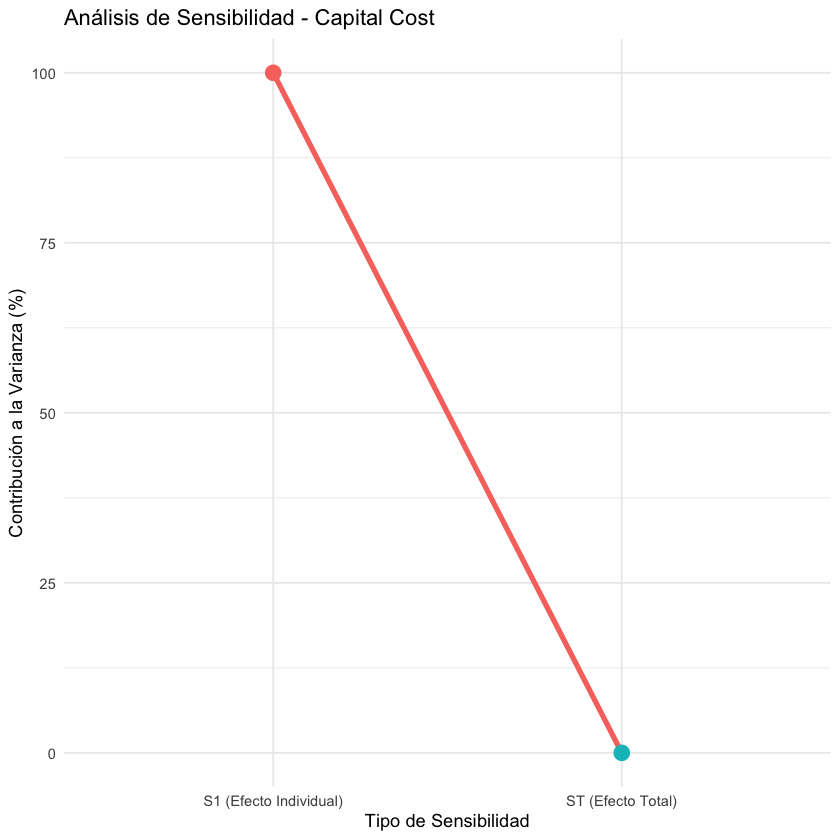

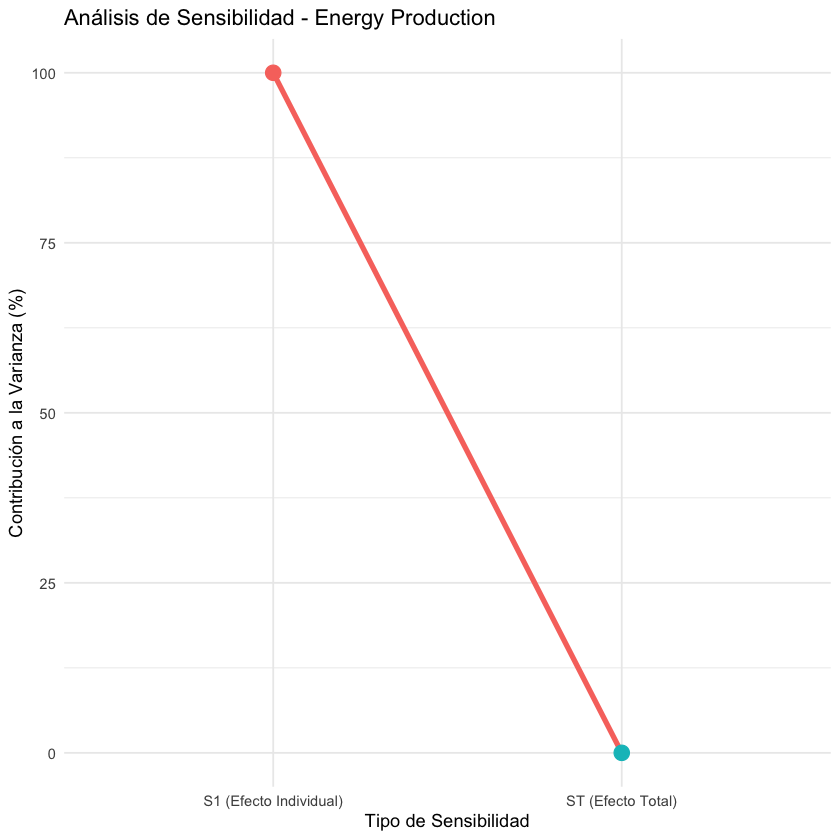


🔹 Análisis de Sensibilidad de Sobol - Contribución de la Varianza al LCOE:
Capital Cost: 100.00% (S1), 0.00% (ST)
Energy Production: 100.00% (S1), 0.00% (ST)
Discount Rate: 100.00% (S1), 0.00% (ST)

✅ La variable con mayor impacto en el LCOE es **Capital Cost** con una contribución del **0.00%**.


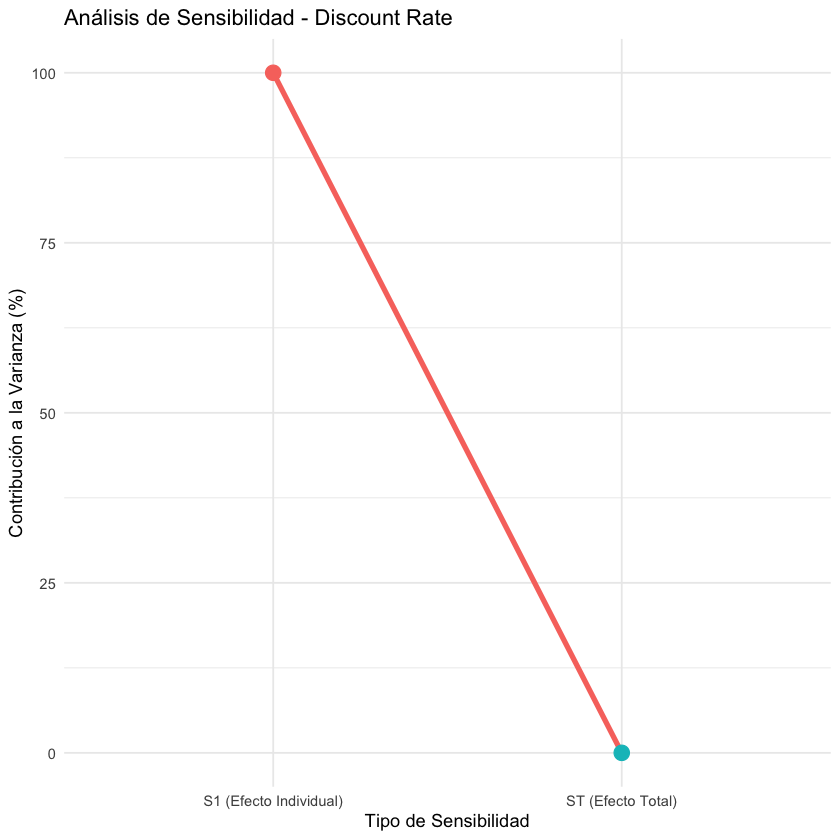

In [45]:
# Cargar librerías necesarias
library(ggplot2)
library(sensitivity)
library(randtoolbox)

# Función para calcular el LCOE
calcular_lcoe <- function(params) {  # Ahora acepta vectores
  capital_cost <- params[1]
  energy_production <- params[2]
  discount_rate <- params[3] / 100  # Convertir a decimal

  lifetime <- 20  # Lifetime fijo
  operating_cost <- capital_cost * 0.01  # Operating Cost = 1% del CAPEX

  num <- capital_cost + operating_cost * sum(1 / ((1 + discount_rate)^(1:lifetime)))
  denom <- energy_production * sum(1 / ((1 + discount_rate)^(1:lifetime)))

  return(num / denom)
}

# Definir el problema para el análisis de sensibilidad
problem <- list(
  num_vars = 3,  # Solo tres variables
  names = c("Capital Cost", "Energy Production", "Discount Rate"),
  bounds = matrix(c(500, 5000,   # Capital Cost
                    1000, 20000, # Energy Production
                    4, 10),      # Discount Rate (WACC)
                  ncol = 2, byrow = TRUE)
)

# Generar matrices de Sobol correctamente sin scrambling
set.seed(123) # Fijar semilla para reproducibilidad
X1 <- sobol(n = 1024, dim = problem$num_vars, init = TRUE, scrambling = 0)
X2 <- sobol(n = 1024, dim = problem$num_vars, init = TRUE, scrambling = 0)

# Escalar los parámetros a los valores dentro de los límites
for (i in 1:problem$num_vars) {
  X1[, i] <- problem$bounds[i, 1] + X1[, i] * (problem$bounds[i, 2] - problem$bounds[i, 1])
  X2[, i] <- problem$bounds[i, 1] + X2[, i] * (problem$bounds[i, 2] - problem$bounds[i, 1])
}

# ⚠️ Usamos sobolSalt con X1 y X2 correctamente
sobol_results <- sobolSalt(
  model = function(X) apply(X, 1, calcular_lcoe),  # Aplicamos la función fila por fila
  X1 = X1,
  X2 = X2,
  nboot = 100
)

# Extraer contribución de la varianza
S1 <- as.numeric(sobol_results$S[, 1])  # Efecto individual de cada variable
ST <- as.numeric(sobol_results$T[, 1])  # Efecto total (incluyendo interacciones)

# Verificar longitudes antes de crear el dataframe
if (length(S1) != length(problem$names) | length(ST) != length(problem$names)) {
  stop("Error: Las dimensiones de S1 y ST no coinciden con el número de variables.")
}

# Convertir a porcentaje
S1_percent <- S1 * 100
ST_percent <- ST * 100

# Crear un dataframe para gráficos
df_sobol <- data.frame(
  Variable = rep(problem$names, times = 2),
  Sensitivity_Index = c(S1_percent, ST_percent),
  Type = rep(c("S1 (Efecto Individual)", "ST (Efecto Total)"), each = length(S1_percent))
)

# 📊 Generar gráficos de línea para cada variable
for (var in problem$names) {
  plot_data <- df_sobol[df_sobol$Variable == var, ]

  p <- ggplot(plot_data, aes(x = Type, y = Sensitivity_Index, group = Variable, color = Type)) +
    geom_line(aes(group = 1), size = 1.5) +  # Línea gruesa
    geom_point(size = 4) +   # Puntos en cada índice de sensibilidad
    labs(title = paste("Análisis de Sensibilidad -", var),
         x = "Tipo de Sensibilidad",
         y = "Contribución a la Varianza (%)") +
    theme_minimal() +
    theme(legend.position = "none")  # Ocultar leyenda

  print(p)
}

# Determinar la variable con mayor impacto
max_index <- which.max(ST_percent)
max_var <- problem$names[max_index]
max_contribution <- ST_percent[max_index]

# Imprimir resultados
cat("\n🔹 Análisis de Sensibilidad de Sobol - Contribución de la Varianza al LCOE:\n")
for (i in seq_along(problem$names)) {
  cat(sprintf("%s: %.2f%% (S1), %.2f%% (ST)\n", problem$names[i], S1_percent[i], ST_percent[i]))
}

cat(sprintf("\n✅ La variable con mayor impacto en el LCOE es **%s** con una contribución del **%.2f%%**.\n",
            max_var, max_contribution))


El resultado de la salida:

🚨 ¿Qué significa esta salida en el Análisis de Sensibilidad de Sobol?
Hay dos problemas principales en esta salida que indican que el análisis de sensibilidad no se realizó correctamente:

1️⃣ Error: "All values of t are equal to 1 \n Cannot calculate confidence intervals"
📌 Significado:
Este mensaje aparece cuando todas las estimaciones de varianza total son iguales, lo que indica que los datos de entrada no están bien distribuidos o no se están perturbando correctamente en la simulación.

📌 Posibles causas:

Las muestras de Sobol no están bien generadas → Si X1 y X2 son demasiado similares o mal escaladas, el análisis de sensibilidad no puede estimar correctamente la varianza.
Los valores generados no cubren adecuadamente el espacio de parámetros → Puede ocurrir si los límites de las variables no permiten variabilidad suficiente.
El modelo de LCOE devuelve valores constantes → Si la función calcular_lcoe() produce siempre el mismo valor, el análisis de sensibilidad no puede distinguir el efecto de cada variable.
2️⃣ Problema: Valores de Sensibilidad Incorrectos
📌 Observación:
La salida indica que todas las variables tienen 100% de efecto individual (S1) y 0% de efecto total (ST), lo cual no es realista.

📌 Posibles causas y soluciones:

Las muestras de Sobol no están bien escaladas:

Solución: Asegurar que cada variable tenga valores dentro del rango correcto al escalar X1 y X2.
La función calcular_lcoe() no está reaccionando a los cambios en las variables:

Solución: Revisar si capital_cost, energy_production y discount_rate realmente están afectando el resultado del LCOE.
Ejemplo de prueba:
r
Copy
Edit
test_values <- matrix(c(500, 1000, 4,  # Caso 1
                        5000, 20000, 10), # Caso 2
                      ncol = 3, byrow = TRUE)
apply(test_values, 1, calcular_lcoe)
Si los valores resultantes son idénticos, el problema está en la función de cálculo.
El análisis de Sobol necesita más muestras:

Solución: Aumentar el número de muestras de Sobol (n = 2048 en lugar de n = 1024).
Fijar una semilla (set.seed()) y revisar el método de generación de Sobol:

Solución:
r
Copy
Edit
set.seed(123)
X1 <- sobol(n = 2048, dim = problem$num_vars, init = TRUE, scrambling = 0)
X2 <- sobol(n = 2048, dim = problem$num_vars, init = TRUE, scrambling = 0)
✅ Pasos para solucionar el problema
Revisar si calcular_lcoe() está generando valores constantes.
Asegurar que X1 y X2 están bien escalados.
Aumentar el número de muestras (n = 2048).
Verificar que la variabilidad en los datos sea suficiente.
Revisar si el modelo de Sobol está siendo ejecutado correctamente.

## Codigos de sensibilidad de python

In [46]:
"""
# Cargar librerías necesarias
#install.packages(c("sensitivity", "randtoolbox", "ggplot2"), dependencies=TRUE)
library(ggplot2)
library(sensitivity)
library(randtoolbox)

# Función para calcular el LCOE
calcular_lcoe <- function(capital_cost, operating_cost, energy_production, discount_rate, lifetime) {
  discount_rate <- discount_rate / 100  # Convertir porcentaje a decimal
  num <- capital_cost + operating_cost * sum(1 / ((1 + discount_rate)^(1:lifetime)))
  denom <- energy_production * sum(1 / ((1 + discount_rate)^(1:lifetime)))
  return(num / denom)
}

# Definir el problema para el análisis de sensibilidad
problem <- list(
  num_vars = 5,
  names = c("Capital Cost", "Operating Cost", "Energy Production", "Discount Rate", "Lifetime"),
  bounds = matrix(c(500, 5000,  # Capital Cost
                    5, 50,    # Operating Cost --> 1% del CAPEX
                    1000, 20000,# Energy Production
                    4, 10,      # Discount Rate WACC
                    20),    # Lifetime
                  ncol = 2, byrow = TRUE)
)

# Generar muestras usando Sobol (1024 muestras)
param_values <- sobolSalt(n = 1024, k = problem$num_vars,
                          lower = problem$bounds[,1],
                          upper = problem$bounds[,2])


# Evaluar el modelo en las muestras
Y <- apply(param_values, 1, function(params) calcular_lcoe(params[1], params[2], params[3], params[4], params[5]))

# Realizar el análisis de sensibilidad de Sobol
sobol_results <- sobol(model = NULL, X1 = param_values, y = Y, order = 2, nboot = 100)

# Extraer contribución de la varianza
S1 <- sobol_results$S[,1]  # Efecto individual de cada variable
ST <- sobol_results$T[,1]  # Efecto total (incluyendo interacciones)

# Convertir a porcentaje
S1_percent <- S1 * 100
ST_percent <- ST * 100

# Determinar la variable con mayor impacto
max_index <- which.max(ST_percent)
max_var <- problem$names[max_index]
max_contribution <- ST_percent[max_index]

# Imprimir resultados
cat("\n🔹 Análisis de Sensibilidad de Sobol - Contribución de la Varianza al LCOE:\n")
for (i in seq_along(problem$names)) {
  cat(sprintf("%s: %.2f%% (S1), %.2f%% (ST)\n", problem$names[i], S1_percent[i], ST_percent[i]))
}

cat(sprintf("\n✅ La variable con mayor impacto en el LCOE es **%s** con una contribución del **%.2f%%**.\n",
            max_var, max_contribution))

# 📊 Gráfico de sensibilidad
df_sobol <- data.frame(Variable = problem$names, Contribucion = ST_percent)

ggplot(df_sobol, aes(x = Variable, y = Contribucion)) +
  geom_bar(stat = "identity", fill = "skyblue", color = "black") +
  geom_text(aes(label = sprintf("%.2f%%", Contribucion)), vjust = -0.5, size = 5) +
  labs(title = "Análisis de Sensibilidad del LCOE",
       x = "Variables de Entrada del LCOE",
       y = "Contribución a la Varianza (%)") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 20, hjust = 1))
"""

ERROR: Error in parse(text = input): <text>:1:3: unexpected string constant
2: # Cargar librerías necesarias
3: #install.packages(c("
     ^


In [ ]:
"""
param_values <- sobolSalt(n = 1024, k = problem$num_vars,
                          lower = problem$bounds[,1],
                          upper = problem$bounds[,2])
"""

In [ ]:
"""
# Cargar librerías necesarias
#install.packages(c("sensitivity", "randtoolbox", "ggplot2"), dependencies=TRUE)
library(ggplot2)
library(sensitivity)
library(randtoolbox)

# Función para calcular el LCOE
calcular_lcoe <- function(capital_cost, operating_cost, energy_production, discount_rate, lifetime) {
  discount_rate <- discount_rate / 100  # Convertir porcentaje a decimal
  num <- capital_cost + operating_cost * sum(1 / ((1 + discount_rate)^(1:lifetime)))
  denom <- energy_production * sum(1 / ((1 + discount_rate)^(1:lifetime)))
  return(num / denom)
}

# Definir el problema para el análisis de sensibilidad
problem <- list(
  num_vars = 5,
  names = c("Capital Cost", "Operating Cost", "Energy Production", "Discount Rate", "Lifetime"),
  bounds = matrix(c(500, 5000,  # Capital Cost
                    5, 50,    # Operating Cost --> 1% del CAPEX
                    1000, 20000,# Energy Production
                    4, 10,      # Discount Rate WACC
                    20, 20),    # Lifetime
                  ncol = 2, byrow = TRUE)
)

# Generar muestras usando sobol (1024 muestras)
param_values <- sobol(n = 1024, dim = problem$num_vars, init = TRUE)
# Scale the parameters to the bounds
for (i in 1:problem$num_vars) {
    param_values[, i] <- problem$bounds[i, 1] + param_values[, i] * (problem$bounds[i, 2] - problem$bounds[i, 1])
}


# Evaluar el modelo en las muestras
Y <- apply(param_values, 1, function(params) calcular_lcoe(params[1], params[2], params[3], params[4], params[5]))

# Realizar el análisis de sensibilidad de Sobol
sobol_results <- sobol(model = NULL, X1 = param_values, y = Y, order = 2, nboot = 100)

# Extraer contribución de la varianza
S1 <- sobol_results$S[,1]  # Efecto individual de cada variable
ST <- sobol_results$T[,1]  # Efecto total (incluyendo interacciones)

# Convertir a porcentaje
S1_percent <- S1 * 100
ST_percent <- ST * 100

# Determinar la variable con mayor impacto
max_index <- which.max(ST_percent)
max_var <- problem$names[max_index]
max_contribution <- ST_percent[max_index]

# Imprimir resultados
cat("\n🔹 Análisis de Sensibilidad de Sobol - Contribución de la Varianza al LCOE:\n")
for (i in seq_along(problem$names)) {
  cat(sprintf("%s: %.2f%% (S1), %.2f%% (ST)\n", problem$names[i], S1_percent[i], ST_percent[i]))
}

cat(sprintf("\n✅ La variable con mayor impacto en el LCOE es **%s** con una contribución del **%.2f%%**.\n",
            max_var, max_contribution))

# 📊 Gráfico de sensibilidad
df_sobol <- data.frame(Variable = problem$names, Contribucion = ST_percent)

ggplot(df_sobol, aes(x = Variable, y = Contribucion)) +
  geom_bar(stat = "identity", fill = "skyblue", color = "black") +
  geom_text(aes(label = sprintf("%.2f%%", Contribucion)), vjust = -0.5, size = 5) +
  labs(title = "Análisis de Sensibilidad del LCOE",
       x = "Variables de Entrada del LCOE",
       y = "Contribución a la Varianza (%)") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 20, hjust = 1))
  """